In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import seaborn as sns
import datetime as dt
import re
from functools import partial
import itertools
from bioinfokit.analys import stat
import scipy.stats as stats
import seaborn as sns
import csv
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
import string
import openpyxl
import json
import urllib.request
import pymongo
import requests
import xml.etree.ElementTree as et
from pprint import pprint
from mpl_toolkits.axes_grid1 import make_axes_locatable
import squarify
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import warnings
#nltk.download('all')

In [2]:
# import csv into a pandas dataframe
imr_df = pd.read_csv(
    "/Users/Bill/Desktop/Syracuse_MIS/IST 652/Project"
    "/Independent_Medical_Review__IMR__Determinations__Trend.csv")

In [3]:
# check dimensions
imr_df.shape

(19245, 11)

In [4]:
# check data structure
imr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19245 entries, 0 to 19244
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Reference ID            19245 non-null  object
 1   Report Year             19245 non-null  int64 
 2   Diagnosis Category      19186 non-null  object
 3   Diagnosis Sub Category  17341 non-null  object
 4   Treatment Category      18795 non-null  object
 5   Treatment Sub Category  17977 non-null  object
 6   Determination           19245 non-null  object
 7   Type                    19245 non-null  object
 8   Age Range               18035 non-null  object
 9   Patient Gender          18035 non-null  object
 10  Findings                19225 non-null  object
dtypes: int64(1), object(10)
memory usage: 1.6+ MB


### Data Munging

In [5]:
# check for inf values
imr_df.isin([np.inf, -np.inf]).any()

Reference ID              False
Report Year               False
Diagnosis Category        False
Diagnosis Sub Category    False
Treatment Category        False
Treatment Sub Category    False
Determination             False
Type                      False
Age Range                 False
Patient Gender            False
Findings                  False
dtype: bool

In [6]:
# check for nan values
imr_df.isna().sum().sort_values(ascending=False)

Diagnosis Sub Category    1904
Treatment Sub Category    1268
Age Range                 1210
Patient Gender            1210
Treatment Category         450
Diagnosis Category          59
Findings                    20
Reference ID                 0
Report Year                  0
Determination                0
Type                         0
dtype: int64

In [7]:
# calculate number and perc of missing values by attribute
na_cnt = imr_df.agg(lambda x: (int(x.isna().sum()), '{:.2f}'.format((x.isna().sum() /
                        len(x))*100)))

In [8]:
# use transpose to move row to header and header to row
na_df = na_cnt.transpose().sort_values(by=0, ascending=False)

# add column names
na_df.columns = ['Total NAs', 'Percent']
na_df

,Total NAs,Percent
Diagnosis Sub Category,1904,9.89
Treatment Sub Category,1268,6.59
Age Range,1210,6.29
Patient Gender,1210,6.29
Treatment Category,450,2.34
Diagnosis Category,59,0.31
Findings,20,0.10
Reference ID,0,0.00
Report Year,0,0.00
Determination,0,0.00


In [9]:
# clean up findings column for data extraction
imr_df['findings_cleaned'] = imr_df['Findings'].str.replace('Nature of Statutory Criteria/Case Summary: ', '')
# convert column to strings and strip white space
imr_df['findings_cleaned'] = imr_df['findings_cleaned'].astype(str).str.strip()

In [10]:
# avg word count per Findings
# create function to count words in string
def word_count(txt):
    words = str(txt).split()
    return len(words)

avg_word_count = imr_df['findings_cleaned'].apply(lambda x: word_count(x)).mean()
print('Average word count in Findings Column: ', round(avg_word_count))

Average word count in Findings Column:  178


In [11]:
# find and extract ages in Findings. create new column with patients age
imr_df['Age'] = imr_df['findings_cleaned'].apply(lambda x: re.search(r'(\d+)-year', x).group(1) \
    if re.search(r'(\d+)-year', x) else None)

In [12]:
# convert age to integer values
imr_df['Age'] = pd.to_numeric(imr_df['Age'], errors='coerce').astype('Int64')

In [13]:
# determine correct age bin for new Age column
# determine bins
imr_df.groupby('Age Range').size()
bins = [0, 10, 20, 30, 40, 50, 65, 1000]
imr_df['age_bucket'] = pd.cut(imr_df['Age'],
                              bins=bins,
                              labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-64', '65+'])

# fill nan values from Age Range with values from age_bucket
imr_df['Age Range'].fillna(imr_df['age_bucket'], inplace=True)

In [14]:
# replace 11_20 to 11-20 to stay consistent with data
imr_df['Age Range'] = imr_df['Age Range'].str.replace('_', '-')

In [15]:
# find genders in Findings column
g_pattern = re.compile(r'\b(?:male|female)\b', flags=re.IGNORECASE)
imr_df['gender'] = imr_df['findings_cleaned'].apply(lambda x: re.search(g_pattern, x).group(0).title() \
    if re.search(g_pattern, x) else None)

# replace nan values in Patient Gender with gender column values
imr_df['Patient Gender'].fillna(imr_df['gender'], inplace=True)

# fix inconsistencies with patient gender column and findings column
imr_df.loc[14954, 'Patient Gender'] = 'Male'

In [16]:
# review new nan values
na_cnt2 = imr_df.iloc[:, :-3].agg(lambda x: (int(x.isna().sum()), '{:.2f}'.format((x.isna().sum() / len(x)) * 100)))
na_df2 = na_cnt2.transpose().sort_values(by=0, ascending=False)
na_df2.columns = ['Total NAs', 'Percent']
na_df2

,Total NAs,Percent
Diagnosis Sub Category,1904,9.89
Treatment Sub Category,1268,6.59
Treatment Category,450,2.34
Age Range,72,0.37
Diagnosis Category,59,0.31
Findings,20,0.10
Patient Gender,9,0.05
Reference ID,0,0.00
Report Year,0,0.00
Determination,0,0.00


# Ryan's Analysis

C:\Users\Bill\AppData\Local\Temp\ipykernel_15644\4105553476.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


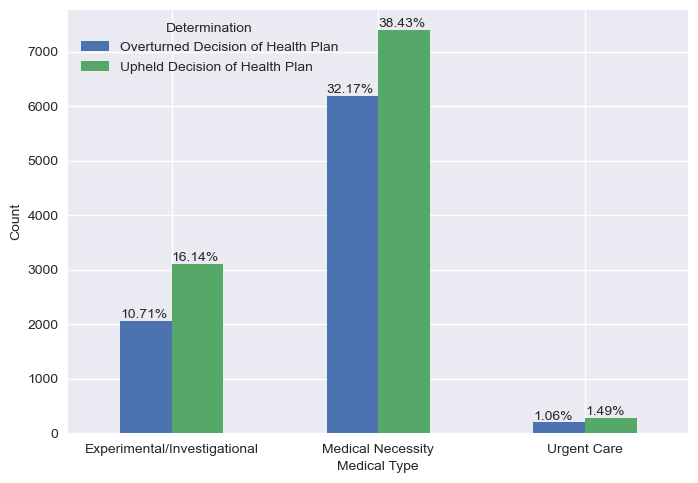

In [17]:
plt.style.use('seaborn')
#plt.style.use('tableau-colorblind10')
ax = imr_df.groupby(['Type', 'Determination']).size().unstack().plot(kind='bar')
totals = []
for i in ax.patches:
    totals.append(i.get_height())   
total = sum(totals)

# add percentages to the bars
for i in ax.patches:
    ax.text(i.get_x(), i.get_height() + 50, '{:.2%}'.format(i.get_height() / total), fontsize=10)
# show the plot
plt.xlabel('Medical Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Statistical Testing

In [18]:
# create a contingency table fo Type and Determinaton
ct = pd.crosstab(index=imr_df['Type'],
                 columns=imr_df['Determination'])
ct

Determination,Overturned Decision of Health Plan,Upheld Decision of Health Plan
Type,,
Experimental/Investigational,2061,3106
Medical Necessity,6192,7396
Urgent Care,204,286


In [19]:
# perform chi-square test of independence to find relationships between attribute of interest
res = stat()
res.chisq(df=ct)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            2       50.1515  1.28745e-11
Log-likelihood     2       50.3911  1.14214e-11



In [20]:
# Gender v Determination
gd = pd.crosstab(index=imr_df['Patient Gender'],
                 columns=imr_df['Determination'],
                 margins=True)
res.chisq(df=gd)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            4      0.383015   0.983844
Log-likelihood     4      0.383061   0.98384



In [21]:
# Age v Determination
ad = pd.crosstab(index=imr_df['Age Range'],
                 columns=imr_df['Determination'],
                 margins=True)
res.chisq(df=ad)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square       P-value
--------------  ----  ------------  ------------
Pearson           14       508.966  1.16528e-99
Log-likelihood    14       509.491  9.01593e-100



In [22]:
# Diagnosis v Determination
dd = pd.crosstab(index=imr_df['Diagnosis Category'],
                 columns=imr_df['Determination'],
                 margins=True)
res.chisq(df=dd)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square       P-value
--------------  ----  ------------  ------------
Pearson           58       1160.94  6.72281e-205
Log-likelihood    58       1185.52  5.57089e-210



# Ryan's Deep Dive Analysis on Gender

### Natural Language Processing

In [23]:
# remove stop words/punctuations
stop_words = set(stopwords.words('english'))
# add additional stop words
stpwrd = nltk.corpus.stopwords.words('english')
new_stopwords = [
    'medical', 'condition', 'treatment', 'enrollee', 'authorization', 'physician', 'reviewer',
    'coverage', 'therapy', 'necessary', 'medically', 'patient', 'procedure', 'health', 'plan',
    'likely', 'beneficial', 'available', 'reviewers', 'denied', 'request', 'proposed', 'experience',
    'expert', 'knowledgeable', 'recent', 'documentation', 'submitted', 'current', 'clinical',
    'result', 'actual', 'independent', 'review', 'denial', 'overturned', 'actively', 'practicing',
    'requested', 'found', 'determined', 'therefore', 'board', 'certified', 'et', 'upon', 'information',
    'experts', 'layperson', 'level', 'standard', 'similar','three', 'language', 'necessity.', 'demonstrate',
    'services', 'issue', 'american', 'performed', 'upheld', 'basis', 'records', 'certification', 'administration',
    'based', 'evidence', 'forth', 'necessity', 'week', 'internal', 'society', 'food'
]
stpwrd.extend(new_stopwords)

In [24]:
# use regex to extract all words after the first occurrence of "requested" up to the end of the sentence.
#req_text = imr_df['findings_cleaned'].apply(lambda x: re.search(r'requested\s+([^\.]+)\.', x).group(1) \
#    if re.search(r'requested\s+([^\.]+)\.', x) else "")

In [25]:
# filter by male
imr_male = imr_df[imr_df['Patient Gender']=='Male']
# filter by female
imr_female = imr_df[imr_df['Patient Gender']=='Female']

In [26]:
# switch between imr_male and imr_female for analysis
req_text = imr_df['findings_cleaned'].apply(lambda x: re.search(r'Findings:\s*(.*)', x).group(1).lstrip() if re.search(r'Findings:\s*(.*)', x) else x)
# male
req_text_m = imr_male['findings_cleaned'].apply(lambda x: re.search(r'Findings:\s*(.*)', x).group(1).lstrip() if re.search(r'Findings:\s*(.*)', x) else x)
# female
req_text_f = imr_female['findings_cleaned'].apply(lambda x: re.search(r'Findings:\s*(.*)', x).group(1).lstrip() if re.search(r'Findings:\s*(.*)', x) else x)

In [27]:
# initialize empty list
req_list = []
# loop through text and convert text to lowercase and remove stopwords
# update req_text to male or female
for index, row in req_text.items():
    sentences = sent_tokenize(row)
    cleaned_words = []
    for s in sentences:
        words = word_tokenize(s)
        words = [word.lower() for word in words if word.isalpha() and word.lower() not in stpwrd]
        # ''.join() converts lists back into single strings
        cleaned_words.append(' '.join(words))
    req_list.append('. '.join(cleaned_words))
req_list = [item.replace('.', '') for item in req_list]

In [28]:
# n-grams: collection of n successive items in req_list
all_ngrams = [ngrams(sentence.split(), 2) for sentence in req_list]
# flatten the list of n-grams
flattened_ngrams = [ngram for sublist in all_ngrams for ngram in sublist]
counter = Counter(flattened_ngrams)
# most common n-grams
most_common = counter.most_common(10)

In [29]:
#  loop through list and print out most common pair of words - bigram
print("\nTop 10 most common bigrams in Female patient's findings:\n")
for i, ((w1, w2), count) in enumerate(most_common, 1):
    print(f'{i}: {w1} {w2} \nOccurrences: {count}\n')


Top 10 most common bigrams in Female patient's findings:

1: hepatitis c 
Occurrences: 1493

2: weight loss 
Occurrences: 1385

3: back pain 
Occurrences: 1203

4: breast cancer 
Occurrences: 1145

5: patients chronic 
Occurrences: 801

6: gastric bypass 
Occurrences: 756

7: disc replacement 
Occurrences: 749

8: growth hormone 
Occurrences: 688

9: fda approved 
Occurrences: 670

10: support use 
Occurrences: 664



In [30]:
# Created a function that will be used to categorize subjectivity analysis on each IMR summary
def subjectivity_to_category(blob):
    if blob.sentiment.subjectivity < 0.2:
        return '1-Very Objective'
    elif 0.4 > blob.sentiment.subjectivity >= .2:
        return '2-Objective'
    elif 0.6 > blob.sentiment.subjectivity >= .4:
        return '3-Neutral'
    elif 0.8 > blob.sentiment.subjectivity >= .6:
        return '4-Subjective'
    else:
        return '5-Very Subjective'

In [31]:
#Taking the original imr_df and renaming it as I intend to add columns for my analysis
imr_df_ryan=imr_df
imr_df_ryan['findings_cleaned']=req_text

#Adding the subjective results (category), the raw subjective results, and the word blob to the dataframe
sub_results=[]
sub_raw_results=[]
blob_results=[]
for text in req_text:
    blob1=TextBlob(text)
    results=subjectivity_to_category(blob1)
    results1=blob1.sentiment.subjectivity
    sub_results.append(results)
    sub_raw_results.append(results1)
    blob_results.append(text)

imr_df_ryan['sub_results']=sub_results
imr_df_ryan['sub_raw_results']=sub_raw_results
imr_df_ryan['word blob']=blob_results

In [32]:
#This function will get the frequency by subjectivity category given a list and a name you'd like to call the results
def count_frequency(list,string):
    frequency=np.unique(list,return_counts=True)
    df=pd.DataFrame(frequency)
    df=df.transpose()
    df.columns=['Level of Subjectivity',string]
    df.set_index('Level of Subjectivity', inplace=True)
    return df

In [33]:
#Called the function to get the subjectivity results between females and males
male_rev = imr_df_ryan[imr_df_ryan['Patient Gender'] == 'Male']
freq_male = count_frequency(male_rev.sub_results,'Male Reviews')
freq_male

,Male Reviews
Level of Subjectivity,
1-Very Objective,437
2-Objective,3994
3-Neutral,3307
4-Subjective,326
5-Very Subjective,40


In [34]:
freq_male.apply(lambda x: x/sum(x))*100

,Male Reviews
Level of Subjectivity,
1-Very Objective,5.392399
2-Objective,49.284304
3-Neutral,40.807009
4-Subjective,4.022705
5-Very Subjective,0.493583


In [35]:
#Called the function to get the subjectivity results between females and males
female_rev = imr_df_ryan[imr_df_ryan['Patient Gender'] == 'Female']
freq_female = count_frequency(female_rev.sub_results,'Female Reviews')

In [36]:
freq_female.apply(lambda x: x/sum(x))*100

,Female Reviews
Level of Subjectivity,
1-Very Objective,5.758175
2-Objective,51.221703
3-Neutral,38.959756
4-Subjective,3.566295
5-Very Subjective,0.494071


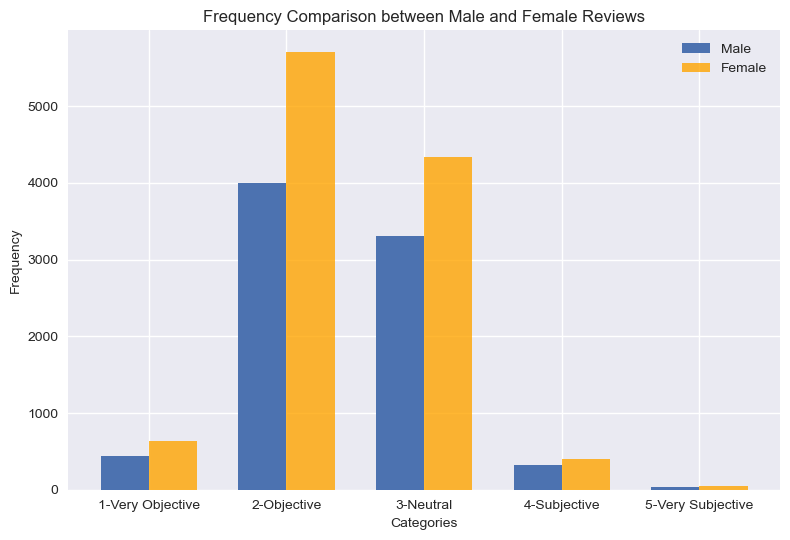

In [37]:
# Data
f_male = freq_male.reset_index()
f_female = freq_female.reset_index()

categories = f_male['Level of Subjectivity']
male_values = f_male['Male Reviews']
female_values = f_female['Female Reviews']

# Plotting
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(categories))

rects1 = ax.bar(index, male_values, bar_width, label='Male')
rects2 = ax.bar(
    [i + bar_width for i in index], 
    female_values, 
    bar_width, 
    label='Female', 
    alpha=0.8, 
    color='orange')

# Set labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Frequency')
ax.set_title('Frequency Comparison between Male and Female Reviews')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(categories)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [38]:
#features = ['Diagnosis Category', 'Diagnosis Sub Category', 'Treatment Category', 'Treatment Sub Category','Determination', 'Type', 'Age Range', 'Patient Gender']

In [39]:
# Preprocess the data by scaling the features
#encoder = OneHotEncoder()
#df_encoded = encoder.fit_transform(imr_df[features]).toarray()

In [40]:
# Preprocess the numerical features by scaling them
#scaler = StandardScaler()

In [41]:
# Suppress the warning
#warnings.filterwarnings("ignore", category=FutureWarning)

# Determine the optimal number of clusters using the elbow method
#inertia = []
#for k in range(1, 15):
#    kmeans = KMeans(n_clusters=k, random_state=0)
#    kmeans.fit(df_encoded)
#    inertia.append(kmeans.inertia_)
    
# Re-enable warnings
#warnings.filterwarnings("default", category=FutureWarning)

In [42]:
# Plot the elbow curve to visualize the optimal number of clusters
#plt.plot(range(1, 15), inertia)
#plt.xlabel('Number of Clusters')
#plt.ylabel('Inertia')
#plt.title('Elbow Curve')
#plt.show()

In [43]:
# Choose the optimal number of clusters based on the elbow curve and create the final model
#k = 9  # Set the optimal number of clusters
#kmeans_final = KMeans(n_clusters=k, random_state=0)
#kmeans_final.fit(df_encoded)

In [44]:
#kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=1000, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
#y_kmeans=kmeans.fit_predict(df_encoded)
#Plotting through K-Means
#plt.scatter(df_encoded[y_kmeans==0,0],df_encoded[y_kmeans==0,1],s=100,c='red',label='Cluster1')
#plt.scatter(df_encoded[y_kmeans==1,0],df_encoded[y_kmeans==1,1],s=100,c='blue',label='Cluster2')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=300,c='yellow',label='Centroids')
#plt.title('Clusters of data')
#plt.legend()
#plt.show()

### Categorical Analysis

In [45]:
# Female vs Male overturned %
gender_ovt = imr_df.groupby('Patient Gender')['Determination'].value_counts().unstack(fill_value=0)
gender_ovt['Total'] = gender_ovt.sum(axis=1)
gender_ovt['Overturned Percentage'] = (gender_ovt['Overturned Decision of Health Plan'] / gender_ovt['Total'] * 100).round(2)

# Rename the columns
gender_ovt.columns = ['Overturned', 'Upheld', 'Total', 'Overturned %']
gender_ovt.iloc[:, [0,1,2,-1]]

,Overturned,Upheld,Total,Overturned %
Patient Gender,,,,
Female,4914,6218,11132,44.14
Male,3541,4563,8104,43.69


In [46]:
# Determinations by Gender and Diagnosis
imr_df.groupby(['Diagnosis Category', 'Patient Gender'])['Determination'].value_counts(normalize=True)

# Group by 'Diagnosis Category', 'Patient Gender', and 'Determination' and calculate the counts
gender_det = imr_df.groupby(['Diagnosis Category', 'Patient Gender', 'Determination']).size().unstack()
gender_det['total'] = gender_det.iloc[:, [0, 1]].sum(axis=1)
gender_det['overturned_perc'] = gender_det.iloc[:, 0] / gender_det['total']
gender_det['upheld_perc'] = gender_det.iloc[:, 1] / gender_det['total']

In [47]:
# unstack and reset indexes so male & female totals are in columns
review = gender_det.unstack().reset_index()
# sum of total cases
review['cases_total'] = review.iloc[:, [5, 6]].sum(axis=1)
# overturned= 7,8; upheld= 9,10
review['perc_diff'] = (review.iloc[:, 7] - review.iloc[:, 8])

# odds ratio - provides a measure of the relative odds or chance of an event occurring between the two groups,
# taking into account the rates or probabilities.
review['odds'] = (review.iloc[:, 7] / review.iloc[:, 8])

# create new column with reciprocal odds
review.loc[:, 'reciprocal_odds'] = review['odds'].apply(lambda x: -1/x if x<1 else x)

# calculate favorability between overturned rates
review['favorability'] = np.where(review['perc_diff']<0, 'Male', 'Female')

# calculate diagnosis category % as a whole
review.loc[:, 'cases_perc'] = (review.iloc[:,11] / review.iloc[:,11].sum())*100

# remove n/a, organ failure, alcohol/drub - insignificant. 74 cases ~ 0.39%
review_d = review.loc[~review.iloc[:, 0].isin(
    ['Not Applicable', 'Organ Failure', 'Alcohol and Drug Addiction', 'OB-Gyn/ Pregnancy'])]

In [48]:
# section out review section to sort by biggest abs overturned differences
review_d.loc[:, 'perc_diff_abs'] = review_d['perc_diff'].abs()

# subset by diag,fav,odds
review_sec = review_d.iloc[:, [0,14,15,16]]

# rename columns
review_sec.columns = ['Diagnosis Category', 'Reciprocal Odds', 'In Favor of', '% of Cases']

review_sec.loc[:,'Reciprocal Odds'] = review_sec['Reciprocal Odds'].abs()

review_sec.iloc[:, [1,3]] = review_sec.iloc[:, [1,3]].apply(lambda x: round(x, 2))

#for index, row in enumerate(review_d):
#    print(index, row)

C:\Users\Bill\AppData\Local\Temp\ipykernel_15644\1703876106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_d.loc[:, 'perc_diff_abs'] = review_d['perc_diff'].abs()
C:\Users\Bill\AppData\Local\Temp\ipykernel_15644\1703876106.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_sec.loc[:,'Reciprocal Odds'] = review_sec['Reciprocal Odds'].abs()
C:\Users\Bill\AppData\Local\Temp\ipykernel_15644\1703876106.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [49]:
review_sec.set_index('Diagnosis Category').sort_values(by='Reciprocal Odds', ascending=False)

,Reciprocal Odds,In Favor of,% of Cases
Diagnosis Category,,,
Chronic Pain,3.09,Female,0.64
Prevention/Good Health,2.45,Female,1.56
Genitourinary/ Kidney,1.62,Male,1.83
Foot,1.39,Male,1.12
Genetic,1.37,Male,0.52
Cancer,1.33,Female,8.76
Post Surgical Complication,1.33,Male,0.44
Skin,1.18,Male,2.51
Endocrine/ Metabolic,1.18,Female,4.06


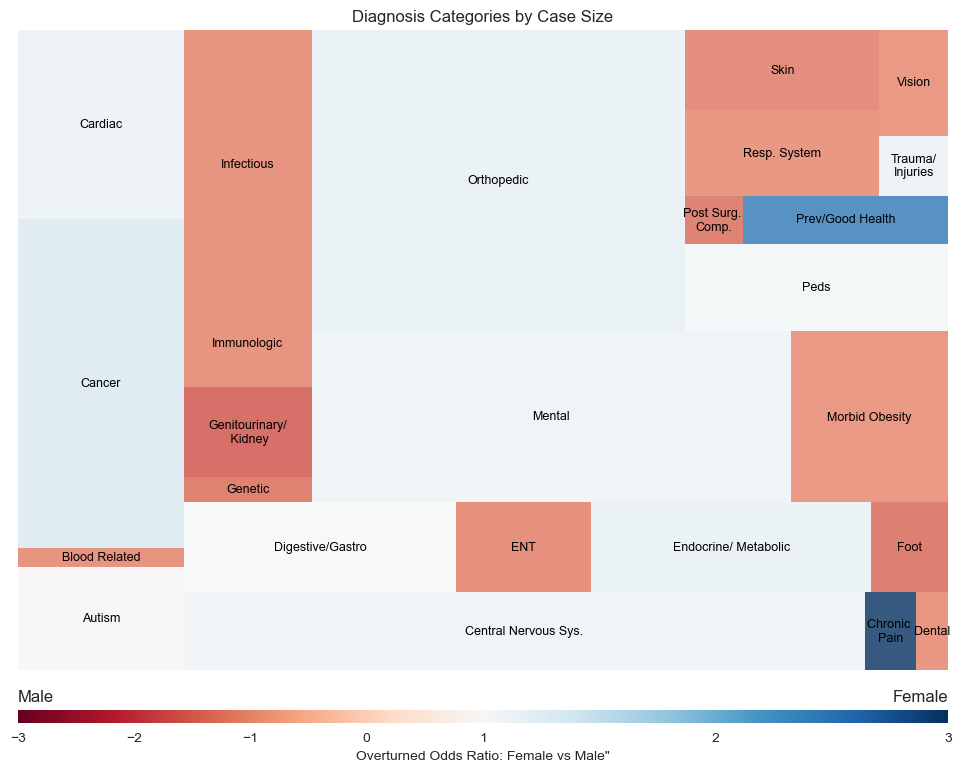

In [50]:
# categories = review_d['Diagnosis Category']
categories = [
    'Autism',
    'Blood Related',
    'Cancer',
    'Cardiac',
    'Central Nervous Sys.',
    'Chronic \nPain',
    'Dental',
    'Digestive/Gastro',
    'ENT',
    'Endocrine/ Metabolic',
    'Foot',
    'Genetic',
    'Genitourinary/\n Kidney',
    'Immunologic',
    'Infectious',
    'Mental',
    'Morbid Obesity',
    'Orthopedic',
    'Peds',
    'Post Surg. \nComp.',
    'Prev/Good Health',
    'Resp. System',
    'Skin',
    'Trauma/\nInjuries',
    'Vision']


# Define a custom color gradient from dark blue to dark red
cmap = matplotlib.colormaps.get_cmap('RdBu')
# set min and max parameters inside Normalize()
# norm = mcolors.Normalize(0.6085106382978723, 3.0909090909090904)
norm = mcolors.TwoSlopeNorm(vmin=-3, vcenter=1, vmax=3)
color_map = cmap(norm(review_d['reciprocal_odds']))


# Create treemap
# plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(12, 9))
squarify.plot(sizes=review_d['cases_total'],
              label=categories,
              color=color_map,
              alpha=0.8,
              text_kwargs={'fontsize': 9, 'color': 'black'})

# Add labels
plt.title('Diagnosis Categories by Case Size')
plt.axis('off')

# Create a colorbar legend
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="2%", pad=.4)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# cbar = plt.colorbar(sm)
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')

# Modify the colorbar title text
cbar.set_label('Overturned Odds Ratio: Female vs Male"', loc='center')
cbar.ax.set_title('Male', loc='left')
cbar.ax.set_title('Female', loc='right')

# Show the plot
plt.show()

In [51]:
# Genitourinary/Kidney Review
gen_review = imr_df.loc[(imr_df['Diagnosis Category'] == 'Genitourinary/ Kidney')]

# Group by 'Diagnosis Category' and 'Patient Gender', and calculate count and percentage
grouped = gen_review.groupby(['Diagnosis Sub Category', 'Patient Gender'])['Determination'].value_counts().unstack(fill_value=0)
grouped['Total'] = grouped.sum(axis=1)
grouped['Overturned Percentage'] = (grouped['Overturned Decision of Health Plan'] / grouped['Total'] * 100).round(2)

# Rename the columns
grouped.columns = ['Overturned', 'Upheld', 'Total', 'Overturned %']
grouped.iloc[:, [0,-1]]

Overturned  Overturned %
Diagnosis Sub Category    Patient Gender                          
Acute Kidney Failure      Female                   3        100.00
                          Male                     2         66.67
Chronic Kidney Failure    Female                   2         25.00
                          Male                     4         66.67
Erectile Dysfunction      Male                    48         64.86
Incontinence              Female                   7         13.46
                          Male                     1         12.50
Interstitial Cystitis     Female                   1          8.33
                          Male                     0          0.00
Kidney Infection          Male                     2        100.00
Kidney Stones             Female                   1         25.00
                          Male                     0          0.00
Male Genital Disorder     Male                    14         50.00
Other                     Female                  12         30.00
                          Male                    17         23.29
Polycystic Kidney Disease Female                   2         66.67
Pyelonephritis            Female                   0          0.00
Urinary Tract Infection   Female                  11         73.33
                          Male                     1         33.33

In [52]:
# chronic pain review
chronic_review = imr_df.loc[(imr_df['Diagnosis Category'] == 'Prevention/Good Health')]

# Group by 'Diagnosis Category' and 'Patient Gender', and calculate count and percentage
chronic_g = chronic_review.groupby(['Treatment Category', 'Patient Gender'])['Determination'].value_counts().unstack(fill_value=0)
chronic_g['Total'] = chronic_g.sum(axis=1)
chronic_g['Overturned Percentage'] = (chronic_g['Overturned Decision of Health Plan'] / chronic_g['Total'] * 100).round(2)

# Rename the columns
chronic_g.columns = ['Overturned', 'Upheld', 'Total', 'Overturned %']
chronic_g

Overturned  \
Treatment Category                                 Patient Gender               
Acute Medical Services - Outpatient                Male                     0   
Cancer Treatment                                   Female                   0   
Diagnostic Imaging, Screening and Testing          Female                 150   
                                                   Male                     6   
Diagnostic/Physician Evaluation                    Female                   0   
                                                   Male                     0   
Electrical/ Thermal/ Radiofreq. Interventions      Male                     0   
General Surgery                                    Female                   0   
                                                   Male                     2   
OB/GYN Procedures                                  Female                   1   
Pharmacy/Prescription Drugs                        Female                   2   
                                                   Male                     2   
Preventive Health Screening                        Female                   3   
                                                   Male                     0   
Reconstructive/Plastic Surgery                     Female                   0   
Rehabilitation Services - Skilled Nursing Facil... Female                   0   
Special Procedure                                  Female                   3   
                                                   Male                     0   

                                                                   Upheld  \
Treatment Category                                 Patient Gender           
Acute Medical Services - Outpatient                Male                 1   
Cancer Treatment                                   Female               1   
Diagnostic Imaging, Screening and Testing          Female              75   
                                                   Male                17   
Diagnostic/Physician Evaluation                    Female               2   
                                                   Male                 2   
Electrical/ Thermal/ Radiofreq. Interventions      Male                 1   
General Surgery                                    Female               2   
                                                   Male                 1   
OB/GYN Procedures                                  Female               0   
Pharmacy/Prescription Drugs                        Female               4   
                                                   Male                 2   
Preventive Health Screening                        Female               3   
                                                   Male                 2   
Reconstructive/Plastic Surgery                     Female               1   
Rehabilitation Services - Skilled Nursing Facil... Female               1   
Special Procedure                                  Female              12   
                                                   Male                 4   

                                                                   Total  \
Treatment Category                                 Patient Gender          
Acute Medical Services - Outpatient                Male                1   
Cancer Treatment                                   Female              1   
Diagnostic Imaging, Screening and Testing          Female            225   
                                                   Male               23   
Diagnostic/Physician Evaluation                    Female              2   
                                                   Male                2   
Electrical/ Thermal/ Radiofreq. Interventions      Male                1   
General Surgery                                    Female              2   
                                                   Male                3   
OB/GYN Procedures                                  Female            

In [53]:
# prevention/good health review
prev_review = imr_df.loc[(imr_df['Diagnosis Category'] == 'Prevention/Good Health')]

prev_review.groupby(['Treatment Category','Patient Gender'])['Determination'].value_counts()


# Group by 'Diagnosis Category' and 'Patient Gender', and calculate count and percentage
prev_g = prev_review.groupby(['Treatment Category', 'Patient Gender'])['Determination'].value_counts().unstack(fill_value=0)
prev_g['Total'] = prev_g.sum(axis=1)
prev_g['Overturned Percentage'] = (prev_g['Overturned Decision of Health Plan'] / prev_g['Total'] * 100).round(2)

# Rename the columns
prev_g.columns = ['Overturned', 'Upheld', 'Total', 'Overturned %']
prev_g

Overturned  \
Treatment Category                                 Patient Gender               
Acute Medical Services - Outpatient                Male                     0   
Cancer Treatment                                   Female                   0   
Diagnostic Imaging, Screening and Testing          Female                 150   
                                                   Male                     6   
Diagnostic/Physician Evaluation                    Female                   0   
                                                   Male                     0   
Electrical/ Thermal/ Radiofreq. Interventions      Male                     0   
General Surgery                                    Female                   0   
                                                   Male                     2   
OB/GYN Procedures                                  Female                   1   
Pharmacy/Prescription Drugs                        Female                   2   
                                                   Male                     2   
Preventive Health Screening                        Female                   3   
                                                   Male                     0   
Reconstructive/Plastic Surgery                     Female                   0   
Rehabilitation Services - Skilled Nursing Facil... Female                   0   
Special Procedure                                  Female                   3   
                                                   Male                     0   

                                                                   Upheld  \
Treatment Category                                 Patient Gender           
Acute Medical Services - Outpatient                Male                 1   
Cancer Treatment                                   Female               1   
Diagnostic Imaging, Screening and Testing          Female              75   
                                                   Male                17   
Diagnostic/Physician Evaluation                    Female               2   
                                                   Male                 2   
Electrical/ Thermal/ Radiofreq. Interventions      Male                 1   
General Surgery                                    Female               2   
                                                   Male                 1   
OB/GYN Procedures                                  Female               0   
Pharmacy/Prescription Drugs                        Female               4   
                                                   Male                 2   
Preventive Health Screening                        Female               3   
                                                   Male                 2   
Reconstructive/Plastic Surgery                     Female               1   
Rehabilitation Services - Skilled Nursing Facil... Female               1   
Special Procedure                                  Female              12   
                                                   Male                 4   

                                                                   Total  \
Treatment Category                                 Patient Gender          
Acute Medical Services - Outpatient                Male                1   
Cancer Treatment                                   Female              1   
Diagnostic Imaging, Screening and Testing          Female            225   
                                                   Male               23   
Diagnostic/Physician Evaluation                    Female              2   
                                                   Male                2   
Electrical/ Thermal/ Radiofreq. Interventions      Male                1   
General Surgery                                    Female              2   
                                                   Male                3   
OB/GYN Procedures                                  Female            

In [54]:
# ortho 
ortho_review = imr_df.loc[(imr_df['Diagnosis Category'] == 'Orthopedic/ Musculoskeletal')]

# Group by 'Diagnosis Category' and 'Patient Gender', and calculate count and percentage
ortho_g = ortho_review.groupby(['Treatment Category', 'Patient Gender'])['Determination'].value_counts().unstack(fill_value=0)
ortho_g['Total'] = ortho_g.sum(axis=1)
ortho_g['Overturned Percentage'] = (ortho_g['Overturned Decision of Health Plan'] / ortho_g['Total'] * 100).round(2)

# Rename the columns
ortho_g.columns = ['Overturned', 'Upheld', 'Total', 'Overturned %']
ortho_g

Overturned  \
Treatment Category                                 Patient Gender               
Acute Medical Services - Inpatient                 Female                   3   
                                                   Male                     2   
Acute Medical Services - Outpatient                Female                  10   
                                                   Male                     7   
Alternative Treatment                              Female                  13   
                                                   Male                     8   
Cancer Treatment                                   Female                   0   
Chiropractic                                       Female                  17   
                                                   Male                    11   
Dental/Orthodontic                                 Female                   8   
                                                   Male                     2   
Diagnostic Imaging, Screening and Testing          Female                  74   
                                                   Male                    34   
Diagnostic/Physician Evaluation                    Female                  17   
                                                   Male                    15   
Durable Medical Equipment                          Female                  67   
                                                   Male                    79   
Electrical/ Thermal/ Radiofreq. Interventions      Female                  28   
                                                   Male                    10   
Emergency/Urgent Care                              Female                   7   
                                                   Male                     3   
General Surgery                                    Female                   7   
                                                   Male                     2   
Home Health Care                                   Female                   1   
                                                   Male                     0   
Mental Health Treatment                            Female                   1   
Neurosugery                                        Female                   7   
                                                   Male                     2   
Not Applicable                                     Female                   1   
                                                   Male                     0   
Orthopedic                                         Female                  99   
                                                   Male                    76   
Pain Management                                    Female                  34   
                                                   Male                    18   
Pharmacy/Prescription Drugs                        Female                 143   
                                                   Male                    74   
Reconstructive/Plastic Surgery                     Female                  28   
                                                   Male                     3   
Rehabilitation Services - Outpatient               Female                  37   
                                                   Male                    15   
Rehabilitation Services - Skilled Nursing Facil... Female                  13   
                                                   Male                     7   
Special Procedure                                  Female                   2   
                                                   Male                     2   

                                                                   Upheld  \
Treatment Category                                 Patient Gender           
Acute Medical Services - Inpatient                 Female               6   
                                                   Male                 2   
Acute Medical Services - Outpati

In [55]:
# cancer
cancer_review = imr_df.loc[(imr_df['Diagnosis Category'] == 'Cancer')]

# Group by 'Diagnosis Category' and 'Patient Gender', and calculate count and percentage
cancer_g = cancer_review.groupby(['Treatment Category', 'Patient Gender'])['Determination'].value_counts().unstack(fill_value=0)
cancer_g['Total'] = cancer_g.sum(axis=1)
cancer_g['Overturned Percentage'] = (cancer_g['Overturned Decision of Health Plan'] / cancer_g['Total'] * 100).round(2)

# Rename the columns
cancer_g.columns = ['Overturned', 'Upheld', 'Total', 'Overturned %']
cancer_g

Overturned  \
Treatment Category                                 Patient Gender               
Acute Medical Services - Inpatient                 Female                   2   
                                                   Male                     1   
Acute Medical Services - Outpatient                Female                   1   
                                                   Male                     2   
Alternative Treatment                              Female                   0   
                                                   Male                     0   
Cancer Treatment                                   Female                 143   
                                                   Male                   153   
Dental/Orthodontic                                 Female                   0   
                                                   Male                     1   
Diagnostic Imaging, Screening and Testing          Female                 247   
                                                   Male                    76   
Diagnostic/Physician Evaluation                    Female                  15   
                                                   Male                     7   
Durable Medical Equipment                          Female                   4   
                                                   Male                     3   
Ear, Nose and Throat Procedures                    Female                   1   
                                                   Male                     0   
Electrical/ Thermal/ Radiofreq. Interventions      Female                  10   
                                                   Male                    12   
General Surgery                                    Female                   5   
                                                   Male                     0   
Home Health Care                                   Female                   1   
                                                   Male                     0   
Not Applicable                                     Female                   2   
OB/GYN Procedures                                  Female                   2   
Orthopedic                                         Female                   1   
Pain Management                                    Male                     2   
Pharmacy/Prescription Drugs                        Female                  24   
                                                   Male                    20   
Preventive Health Screening                        Female                   0   
Reconstructive/Plastic Surgery                     Female                  10   
                                                   Male                     0   
Rehabilitation Services - Outpatient               Female                   2   
Rehabilitation Services - Skilled Nursing Facil... Female                   1   
                                                   Male                     2   
Special Procedure                                  Female                   7   
                                                   Male                     8   
Urology                                            Male                     2   

                                                                   Upheld  \
Treatment Category                                 Patient Gender           
Acute Medical Services - Inpatient                 Female               4   
                                                   Male                 2   
Acute Medical Services - Outpatient                Female               0   
                                                   Male                 0   
Alternative Treatment                              Female               1   
                                                   Male                 1   
Cancer Treatment                                   Female             213   
                                                   M

In [56]:
# mental health
mental_review = imr_df.loc[(imr_df['Diagnosis Category'] == 'Mental')]

# Group by 'Diagnosis Category' and 'Patient Gender', and calculate count and percentage
mental_g = mental_review.groupby(['Treatment Category', 'Patient Gender'])['Determination'].value_counts().unstack(fill_value=0)
mental_g['Total'] = mental_g.sum(axis=1)
mental_g['Overturned Percentage'] = (mental_g['Overturned Decision of Health Plan'] / mental_g['Total'] * 100).round(2)

# Rename the columns
mental_g.columns = ['Overturned', 'Upheld', 'Total', 'Overturned %']
mental_g

Overturned  \
Treatment Category                                 Patient Gender               
Acute Medical Services - Inpatient                 Female                   7   
                                                   Male                     1   
Acute Medical Services - Outpatient                Female                   0   
                                                   Male                     6   
Alternative Treatment                              Female                   5   
                                                   Male                     2   
Autism Related Treatment                           Female                   0   
                                                   Male                     2   
Dental/Orthodontic                                 Female                   1   
Diagnostic Imaging, Screening and Testing          Female                   1   
                                                   Male                     2   
Diagnostic/Physician Evaluation                    Female                   5   
                                                   Male                     4   
Durable Medical Equipment                          Female                   0   
                                                   Male                     2   
Electrical/ Thermal/ Radiofreq. Interventions      Female                  61   
                                                   Male                    37   
Emergency/Urgent Care                              Female                   2   
                                                   Male                     4   
General Surgery                                    Female                   3   
                                                   Male                     1   
Home Health Care                                   Male                     2   
Mental Health Treatment                            Female                 497   
                                                   Male                   312   
Neurosugery                                        Female                   1   
                                                   Male                     0   
OB/GYN Procedures                                  Male                     1   
Pain Management                                    Female                   1   
Pharmacy/Prescription Drugs                        Female                  56   
                                                   Male                    44   
Preventive Health Screening                        Male                     1   
Reconstructive/Plastic Surgery                     Female                  11   
                                                   Male                     1   
Rehabilitation Services - Outpatient               Female                  17   
                                                   Male                    58   
Rehabilitation Services - Skilled Nursing Facil... Female                   5   
                                                   Male                     3   
Special Procedure                                  Female                   1   
                                                   Male                     0   
Vision                                             Female                   0   

                                                                   Upheld  \
Treatment Category                                 Patient Gender           
Acute Medical Services - Inpatient                 Female               6   
                                                   Male                 5   
Acute Medical Services - Outpatient                Female               1   
                                                   Male                 4   
Alternative Treatment                              Female              19   
                                                   Male                13   
Autism Related Treatment                        

# Bill's Analysis

In [57]:
# Bill Steel.  Date: 5/1/2023-5/6/2023

'''The following portion of HW1 examines 3 questions from the IMR data (Indepedent Medical Review) consisting 
of over 19000 medial reviews of a claim against an insurance plan's refusal of payment for services.  

The imr_df dataframe is a pandas dataframe based on .csv file obtained from Kaggle.

Question 1:  Are there any differences/biases in determination results based on gender?  
Question 2:  Are there any differences in outcomes based on Age Range? 
Question 3:  Are there any differences based on the type of Physician/Disease Condition?

Objectives:  Do analysis based on statistics and visually show results (e.g., bar charts)

A review of "Overturned" means the insurance company has been overruled, while "Upheld" 
means the IMR sided with the Insurance Company.'''


#baseline of total overturned vs. upheld
count=0
overturned=0
upheld=0
unknown=0
while count < len(imr_df):
    if imr_df.loc[count,'Determination']=='Overturned Decision of Health Plan':
        overturned=overturned+1
    else:
        if imr_df.loc[count,'Determination']=='Upheld Decision of Health Plan':
            upheld=upheld+1
        else:  #this statement checks for missing/corrupted data
            unknown=unknown+1
    count=count+1

print('overturned: {:,}, upheld: {:,}, unknown: {:,}'.format(overturned,upheld,unknown))
print('total records: {:,}'.format(len(imr_df)))
print('Percent overturned: {:.2f}%'.format(overturned/(overturned+upheld)*100))

overturned: 8,457, upheld: 10,788, unknown: 0
total records: 19,245
Percent overturned: 43.94%


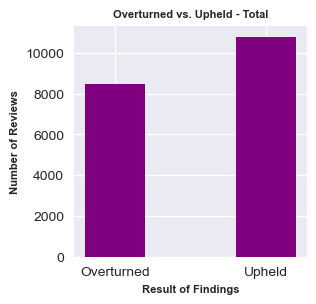

In [58]:
#Plot a bar chart of overall reviews showing upheld vs oveturned

data={'Overturned':overturned,'Upheld':upheld}
xaxis=list(data.keys())
yaxis=list(data.values())
fig=plt.figure(figsize=(3,3))
plt.bar(xaxis,yaxis,color='purple',width=.4)
plt.xlabel("Result of Findings",fontweight='bold',fontsize=8)
plt.ylabel("Number of Reviews",fontweight='bold',fontsize=8)
plt.title("Overturned vs. Upheld - Total",fontweight='bold',fontsize=8)
plt.show()

In [59]:
#Determine overturned vs. upheld by gender

count=0
male=0
female=0
unknown=0
m_overturned=0
f_overturned=0
m_upheld=0
f_upheld=0
while count < len(imr_df):
    if imr_df.loc[count,'Patient Gender']=='Male':
        male=male+1
        if imr_df.loc[count,'Determination']=='Overturned Decision of Health Plan':
            m_overturned=m_overturned+1
        elif imr_df.loc[count,'Determination']=='Upheld Decision of Health Plan':
            m_upheld=m_upheld+1
    else:
        if imr_df.loc[count,'Patient Gender']=='Female':
            female=female+1
            if imr_df.loc[count,'Determination']=='Overturned Decision of Health Plan':
                f_overturned=f_overturned+1
            elif imr_df.loc[count,'Determination']=='Upheld Decision of Health Plan':
                f_upheld=f_upheld+1
        else:  #this statement checks for missing/corrupted data
            unknown=unknown+1
    count=count+1

percent_female = round(f_overturned/female*100,2)
percent_male = round(m_overturned/male*100,2)

print('Male: {}, Female: {}, missing/other: {}'.format(male,female,unknown))
print('Percent of claims related to Males {:.2f}%'.format(male/(male+female)*100))
print('Percent of claims related to Females {:.2f}%'.format(female/(male+female)*100))
print('total records: {}'.format(len(imr_df)))
print('Total valid records =',(male+female))
print('Male Overturned',m_overturned)
print('Male Upheld',m_upheld)
print('Female Overturned',f_overturned)
print('Female Upheld',f_upheld)
print('Female Overturned {:.2f}%'.format(percent_female))
print('Male Overturned {:.2f}%'.format(percent_male))

Male: 8104, Female: 11132, missing/other: 9
Percent of claims related to Males 42.13%
Percent of claims related to Females 57.87%
total records: 19245
Total valid records = 19236
Male Overturned 3541
Male Upheld 4563
Female Overturned 4914
Female Upheld 6218
Female Overturned 44.14%
Male Overturned 43.69%


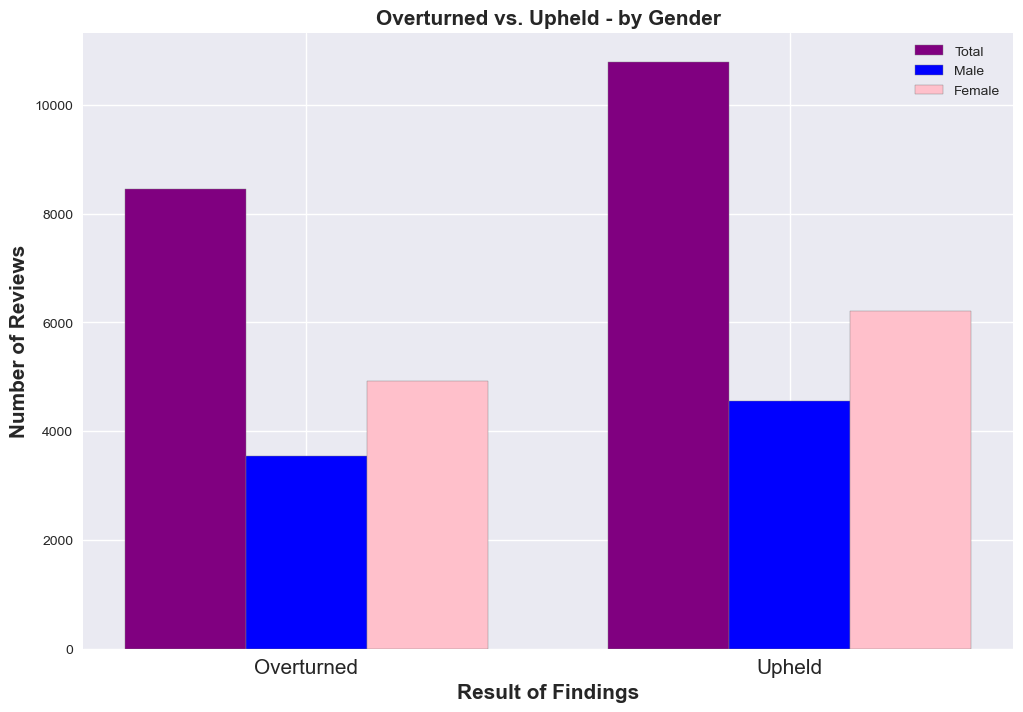

In [60]:
#Builds the plot showing overturned vs. upheld by total, males, and females

barWidth=.25
fig=plt.subplots(figsize=(12,8))

total=[overturned,upheld]
male_total=[m_overturned,m_upheld]
female_total=[f_overturned,f_upheld]
      
br1=np.arange(len(total))
br2=[x+barWidth for x in br1]
br3=[x+barWidth for x in br2]

plt.bar(br1,total,color='purple', width=barWidth,edgecolor='grey',label='Total')
plt.bar(br2,male_total,color='b',width=barWidth,edgecolor='grey',label='Male')
plt.bar(br3,female_total,color='pink',width=barWidth,edgecolor='grey',label='Female')

plt.xlabel('Result of Findings',fontweight='bold',fontsize=15)
plt.ylabel('Number of Reviews', fontweight='bold',fontsize=15)
plt.title("Overturned vs. Upheld - by Gender",fontweight='bold',fontsize=15)
plt.xticks([r+barWidth for r in range(len(total))],['Overturned', 'Upheld'],fontsize=15)
plt.legend()

In [61]:
#Overturned by age group
x=imr_df.groupby(['Determination','Age Range'])['Reference ID'].count()
imr_grouped_list=[]
row=[]
count=0
while count < len(x):
    row=[x.index[count][0],x.index[count][1],x[count]]
    imr_grouped_list.append(row)
    count += 1
df=pd.DataFrame(imr_grouped_list,columns=['Determination','Age Range','Total'])

o_percent_by_age_group=[]
count=0
while count<int(len(df)/2):
    percent=round((int(df.loc[count][2])/(int(df.loc[count][2])+int(df.loc[count+7][2])))*100,2)
    age_group=df.loc[count][1]
    o_percent_by_age_group.append([age_group,percent])
    count += 1

percent_df=pd.DataFrame(o_percent_by_age_group,columns=['Age Range','Percent Overturned'])
percent_df

,Age Range,Percent Overturned
0,0-10,67.23
1,11-20,48.04
2,21-30,44.10
3,31-40,41.82
4,41-50,37.91
5,51-64,41.40
6,65+,37.31


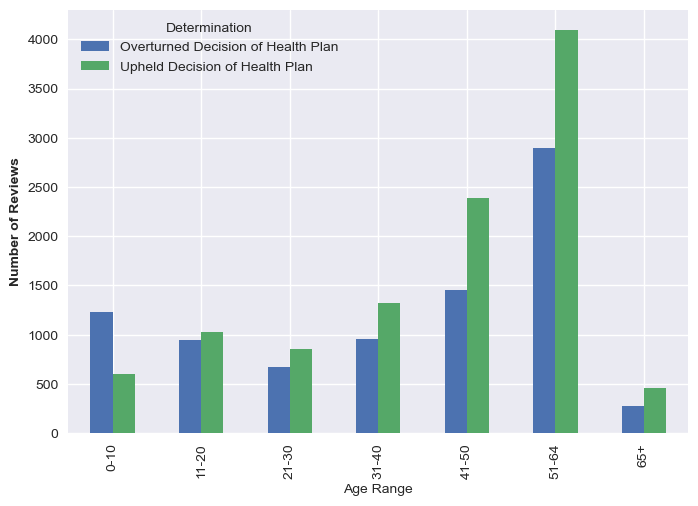

In [62]:
#Overturned by age goup plot
df.pivot(index="Age Range", 
         columns= "Determination", 
         values = "Total").plot(kind='bar')

plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.ylabel('Number of Reviews', fontweight='bold',fontsize=10)
plt.show()

<Axes: xlabel='Age Range'>

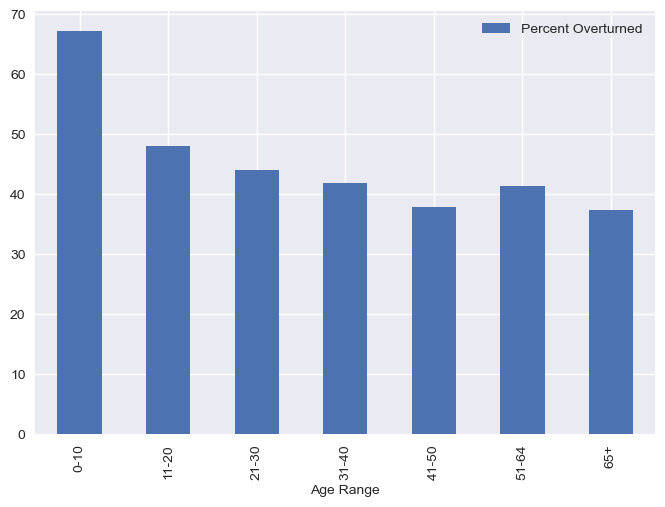

In [63]:
#Percent overturned by Age Group
percent_df=pd.DataFrame(o_percent_by_age_group,columns=['Age Range','Percent Overturned'])
percent_df.set_index('Age Range', inplace=True)
percent_df.plot(kind='bar')

In [64]:
#Question:  Is there a relationship between the outcome of an IMR determination 
#and the medical specialty of the physician who made the determination? 

x=imr_df.groupby(['Determination','Diagnosis Category'])['Reference ID'].count()
imr_grouped_list2=[]
row=[]
count=0
while count < len(x):
    row=[x.index[count][0],x.index[count][1],x[count]]
    imr_grouped_list2.append(row)
    count += 1

imr_grouped_list2

df=pd.DataFrame(imr_grouped_list2,columns=['Determination','Physician Type','Total'])

o_percent_by_pt=[]
count=0
while count<int(len(df)/2):
    percent=round((int(df.loc[count][2])/(int(df.loc[count][2])+int(df.loc[count+29][2])))*100,2)
    total_reviews=df.loc[count][2]+df.loc[count+29][2]
    pt_group=df.loc[count][1]
    o_percent_by_pt.append([pt_group,percent,total_reviews])
    count += 1

percent_df=pd.DataFrame(o_percent_by_pt,columns=['Physician Type','Percent Overturned','Total Reviews'])
percent_df  

,Physician Type,Percent Overturned,Total Reviews
0,Alcohol and Drug Addiction,33.33,3
1,Autism Spectrum,77.10,524
2,Blood Related,43.56,101
3,Cancer,45.75,1681
4,Cardiac/Circulatory,34.61,965
5,Central Nervous System/ Neuromuscular,46.48,1620
6,Chronic Pain,22.13,122
7,Dental,57.89,76
8,Digestive System/ Gastrointestinal,33.64,758
9,"Ears, Nose, Throat",38.03,376


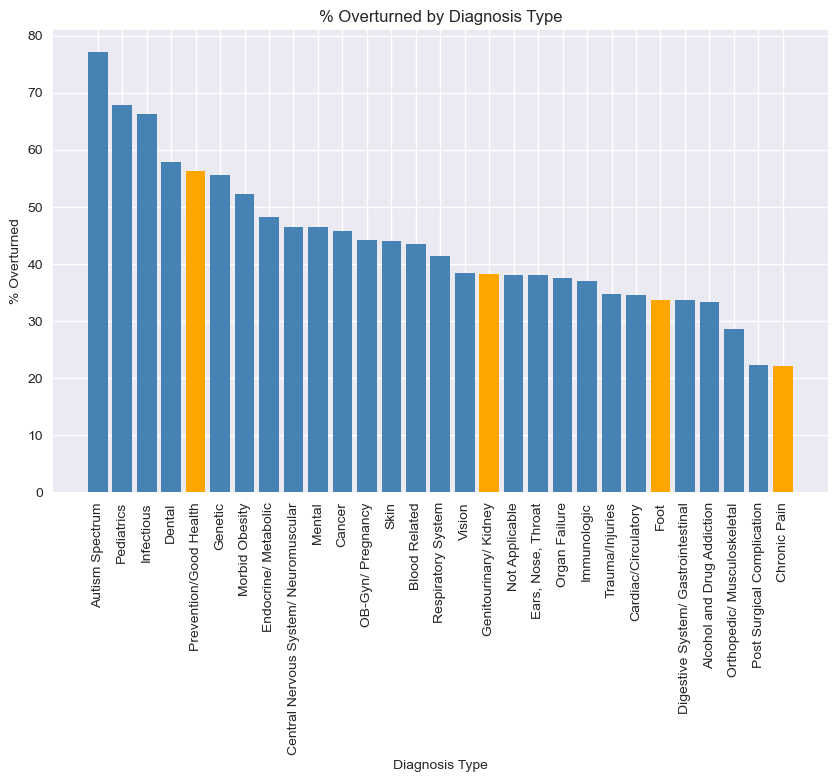

In [65]:

# Sort the DataFrame by percent overturned in descending order
percent_df_sorted = percent_df.sort_values('Percent Overturned', ascending=False)

# Define the colors for the bars
default_color = 'steelblue'
special_colors = {
    'Chronic Pain': 'orange', 
    'Prevention/Good Health': 'orange',
    'Genitourinary/ Kidney': 'orange', 
    'Foot': 'orange'}
        
# Map colors to physician types
bar_colors = percent_df_sorted['Physician Type'].map(special_colors).fillna(default_color)


# Set up the plot
plt.figure(figsize=(10, 6))
plt.bar(percent_df_sorted['Physician Type'], percent_df_sorted['Percent Overturned'], color=bar_colors)

# Set axis labels and title
plt.xlabel('Diagnosis Type')
plt.ylabel('% Overturned')
plt.title('% Overturned by Diagnosis Type')

# Rotate the x-axis labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()


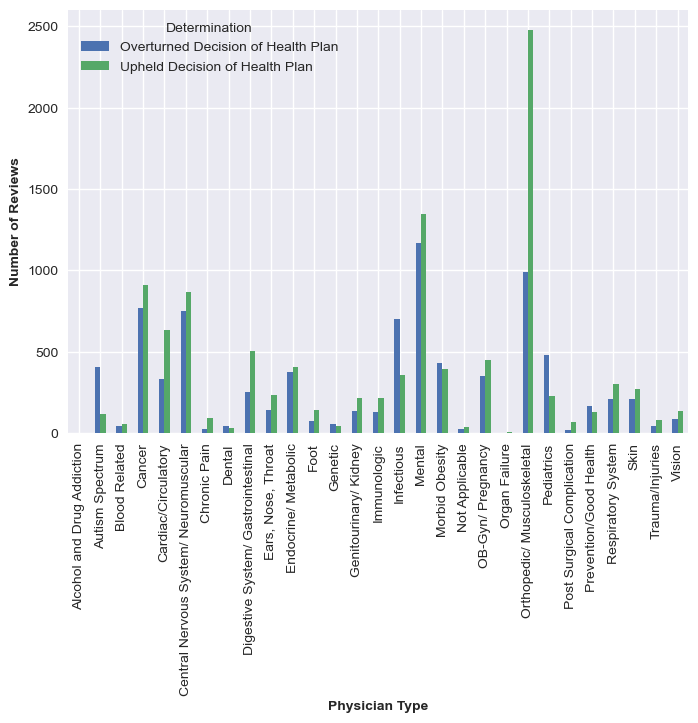

In [66]:
#Prepare the plot of determination by Physician Type

df.pivot(index="Physician Type", 
         columns="Determination",
         values="Total").plot(kind='bar')

plt.rc('xtick',labelsize=5)

plt.ylabel('Number of Reviews', fontweight='bold',fontsize=10)
plt.xlabel('Physician Type', fontweight='bold',fontsize=10)

plt.show()

<Axes: xlabel='Physician Type'>

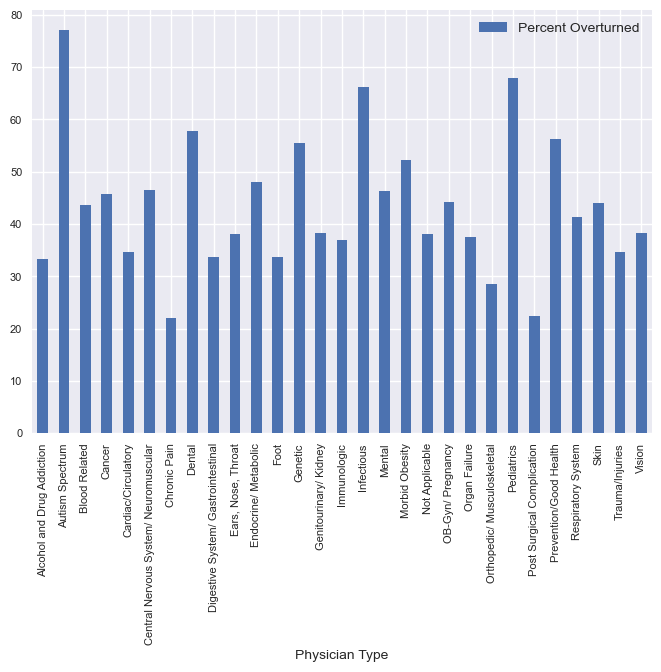

In [67]:
#Percent overturned by Physician Type

percent_df=pd.DataFrame(o_percent_by_pt,columns=['Physician Type','Percent Overturned','Total Reviews'])
percent_df.set_index('Physician Type', inplace=True)
percent_df.drop('Total Reviews',axis=1,inplace=True)
percent_df.plot(kind='bar',fontsize=8)


# Bill's Subjectivity Analysis (Unstructured DataSet)

In [68]:
'''This section of the project code focuses on Subjectivity analysis against 19245 reviews that average about 300 words
per review.  The reviews were written by the IMR board members justifying their concusion to either uphold or overturn

an insurance company's denial of services.  The questions being looked at here are:

1.  Are the reviews objective/professional or does subjectivity enter into the summaries?
2.  Is there any difference as it relates to Upheld vs. Overturned summaries?
3.  Are there any differences in subjectivity regarding different patient age groups?
'''

#Imports to support subjectivity analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

#Created a function that will be used to categorize subjectivity analysis on each IMR summary
def subjectivity_to_category(blob):
    if blob.sentiment.subjectivity < 0.2:
        return '1-Very Objective'
    elif 0.4 > blob.sentiment.subjectivity >= .2:
        return '2-Objective'
    elif 0.6 > blob.sentiment.subjectivity >= .4:
        return '3-Neutral'
    elif 0.8 > blob.sentiment.subjectivity >= .6:
        return '4-Subjective'
    else:
        return '5-Very Subjective'

In [69]:
#Taking the original imr_df and renaming it as I intend to add columns for my analysis
imr_df_bill=imr_df
imr_df_bill['findings_cleaned']=req_text

#Adding the subjective results (category), the raw subjective results, and the word blob to the dataframe
sub_results=[]
sub_raw_results=[]
blob_results=[]
for text in req_text:
    blob1=TextBlob(text)
    results=subjectivity_to_category(blob1)
    results1=blob1.sentiment.subjectivity
    sub_results.append(results)
    sub_raw_results.append(results1)
    blob_results.append(text)

imr_df_bill['sub_results']=sub_results
imr_df_bill['sub_raw_results']=sub_raw_results
imr_df_bill['word blob']=blob_results

In [70]:
#Sepearating out the dataframe for by over turned, upheld, and by various age groups

imr_df_bill_over=[]
imr_df_bill_up=[]
imr_df_bill_age1=[] #intialize for age group 0-10
imr_df_bill_age2=[] #intialize for age group 11-20
imr_df_bill_age3=[] #intialize for age group 21-30
imr_df_bill_age4=[] #intialize for age group 31-40
imr_df_bill_age5=[] #intialize for age group 41-50
imr_df_bill_age6=[] #intialize for age group 51-64
imr_df_bill_age7=[] #intialize for age group 65+
row=0
while row < len(imr_df_bill):
    if imr_df_bill.loc[row]['Determination']=='Overturned Decision of Health Plan':
        imr_df_bill_over.append(imr_df_bill.loc[row])
    if imr_df_bill.loc[row]['Determination']=='Upheld Decision of Health Plan':
        imr_df_bill_up.append(imr_df_bill.loc[row])
    if imr_df_bill.loc[row]['Age Range']=='0-10':
        imr_df_bill_age1.append(imr_df_bill.loc[row])
    if imr_df_bill.loc[row]['Age Range']=='11-20':
        imr_df_bill_age2.append(imr_df_bill.loc[row])
    if imr_df_bill.loc[row]['Age Range']=='21-30':
        imr_df_bill_age3.append(imr_df_bill.loc[row])
    if imr_df_bill.loc[row]['Age Range']=='31-40':
        imr_df_bill_age4.append(imr_df_bill.loc[row])
    if imr_df_bill.loc[row]['Age Range']=='41-50':
        imr_df_bill_age5.append(imr_df_bill.loc[row])
    if imr_df_bill.loc[row]['Age Range']=='51-64':
        imr_df_bill_age6.append(imr_df_bill.loc[row])
    if imr_df_bill.loc[row]['Age Range']=='65+':
        imr_df_bill_age7.append(imr_df_bill.loc[row])
    row += 1

imr_df_bill_over=pd.DataFrame(imr_df_bill_over)
imr_df_bill_up=pd.DataFrame(imr_df_bill_up)
imr_df_bill_age1=pd.DataFrame(imr_df_bill_age1)
imr_df_bill_age2=pd.DataFrame(imr_df_bill_age2)
imr_df_bill_age3=pd.DataFrame(imr_df_bill_age3)
imr_df_bill_age4=pd.DataFrame(imr_df_bill_age4)
imr_df_bill_age5=pd.DataFrame(imr_df_bill_age5)
imr_df_bill_age6=pd.DataFrame(imr_df_bill_age6)
imr_df_bill_age7=pd.DataFrame(imr_df_bill_age7)

In [71]:
#This function will get the frequency by subjectivity category given a list and a name you'd like to call the results
def count_frequency(list,string):
    frequency=np.unique(list,return_counts=True)
    df=pd.DataFrame(frequency)
    df=df.transpose()
    df.columns=['Level of Subjectivity',string]
    df.set_index('Level of Subjectivity', inplace=True)
    return df

#Called the function to get the subjectivity results for all 19245 reviews
frequency_all=count_frequency(imr_df_bill.sub_results,'All Reviews')
frequency_all

,All Reviews
Level of Subjectivity,
1-Very Objective,1080
2-Objective,9702
3-Neutral,7645
4-Subjective,723
5-Very Subjective,95


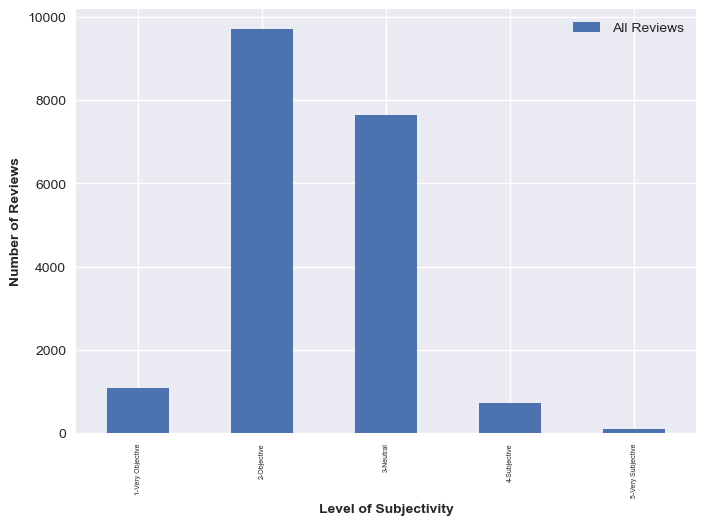

In [72]:
#This Creates a bar chart with the subjectivity analysis for all reviews

frequency_all.plot(kind='bar')
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.ylabel('Number of Reviews', fontweight='bold',fontsize=10)
plt.xlabel('Level of Subjectivity', fontweight='bold',fontsize=10)
plt.show()

In [73]:
#This code breaks out the subjectivity by Upheld vs Overturned

frequency_upheld=count_frequency(imr_df_bill_up.sub_results,'Upheld')
frequency_overturned=count_frequency(imr_df_bill_over.sub_results,'Overturned')

freq_merged_by_det = pd.concat([frequency_upheld, frequency_overturned['Overturned']], axis=1)
freq_merged_by_det

,Upheld,Overturned
Level of Subjectivity,,
1-Very Objective,746,334
2-Objective,5680,4022
3-Neutral,3968,3677
4-Subjective,336,387
5-Very Subjective,58,37


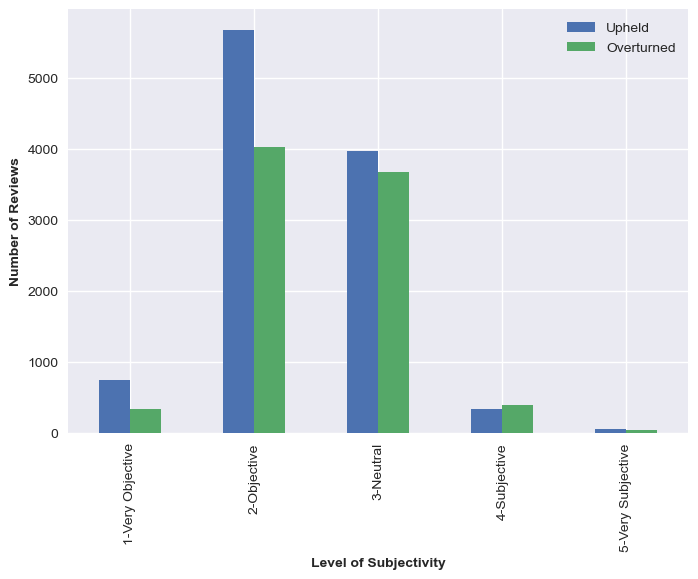

In [74]:
#This code generates a bar graph of the subjectivity by Upheld vs Overturned

freq_merged_by_det.plot(kind='bar')
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.ylabel('Number of Reviews', fontweight='bold',fontsize=10)
plt.xlabel('Level of Subjectivity', fontweight='bold',fontsize=10)
plt.show()


In [75]:
#This code creates a dataframe that identifies subjectivity by Age Group

frequency_age1=count_frequency(imr_df_bill_age1.sub_results,'0-10')
frequency_age2=count_frequency(imr_df_bill_age2.sub_results,'11-20')
frequency_age3=count_frequency(imr_df_bill_age3.sub_results,'21-30')
frequency_age4=count_frequency(imr_df_bill_age4.sub_results,'31-40')
frequency_age5=count_frequency(imr_df_bill_age5.sub_results,'41-50')
frequency_age6=count_frequency(imr_df_bill_age6.sub_results,'51-64')
frequency_age7=count_frequency(imr_df_bill_age7.sub_results,'65+')

freq_merged_by_age = pd.concat([frequency_age1,
                                frequency_age2['11-20'], 
                                frequency_age3['21-30'],
                                frequency_age4['31-40'],
                                frequency_age5['41-50'],
                                frequency_age6['51-64'],
                                frequency_age7['65+']], axis=1)

freq_merged_by_age=freq_merged_by_age.transpose()
freq_merged_by_age.index = freq_merged_by_age.index.rename('Age Range')
freq_merged_by_age

Level of Subjectivity,1-Very Objective,2-Objective,3-Neutral,4-Subjective,5-Very Subjective
Age Range,,,,,
0-10,84,759,868,113,7
11-20,112,920,850,70,17
21-30,72,798,608,48,7
31-40,156,1157,863,95,8
41-50,244,1974,1480,126,17
51-64,368,3654,2683,249,37
65+,32,388,285,22,2


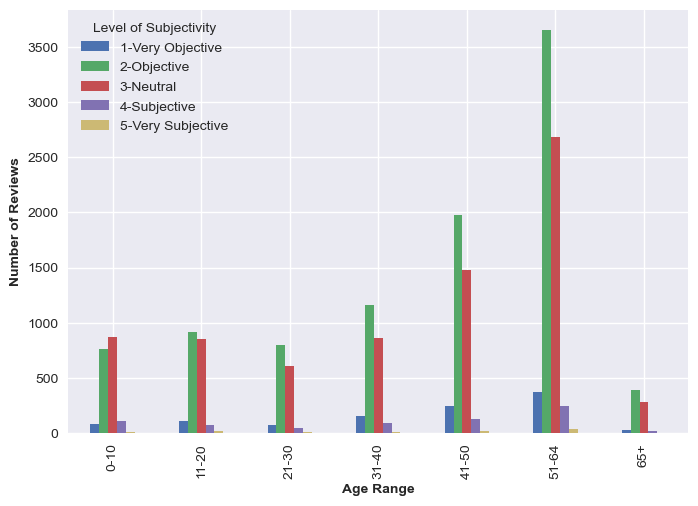

In [76]:
#This code generates a bar graph of subjectivity by Age Group

freq_merged_by_age.plot(kind='bar')
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.ylabel('Number of Reviews', fontweight='bold',fontsize=10)
plt.xlabel('Age Range', fontweight='bold',fontsize=10)
plt.show()

# Bill's Deep Dive Analysis

In [77]:
'''This section of the project code focuses on doing a deep dive analysis on previous conclusions.  
In particular, outlier analysis on “Overturned vs. Upheld by Physician Type”:
  
Key Questions:
For any outlier conclusion, is there anything by year that has skewed the results?  Or has this been generally 
the same year-by-year?

The analysis centers around the following points:
1.  The largest number of IMR reviews is by far within the orthopedic/musculoskeletal category (~3500).  
It also has one of the lowest overturn rates (only 28.54%).
2.  Three diagnosis categories (Physician Types) are commonly overturned with a rate that is more than 2 times 
that of the rate of upholding the insurance companies’ decisions; these being Autism, Infectious diseases, and Pediatrics.
'''

#This code creates 2 data frames from the original.  
#One is for the diagnosis categories that were overturned (3 of them), 
#The other is for the Orthopedic/Musculoskeletel category

row=0
imr_df_diag=[]
imr_df_orth=[]
while row < len(imr_df):
    if imr_df.at[row,'Diagnosis Category'] in ('Infectious','Autism Spectrum','Pediatrics'):
        imr_df_diag.append(imr_df.loc[row])
    if imr_df.at[row,'Diagnosis Category']=='Orthopedic/ Musculoskeletal':
        imr_df_orth.append(imr_df.loc[row])
    row += 1
          
imr_df_diag=pd.DataFrame(imr_df_diag)
imr_df_orth=pd.DataFrame(imr_df_orth)

In [78]:
#creates a summary dataframe

x=imr_df_diag.groupby(['Determination','Diagnosis Category'])['Reference ID'].count()
imr_grouped_list2=[]
row=[]
count=0
while count < len(x):
    row=[x.index[count][0],x.index[count][1],x[count]]
    imr_grouped_list2.append(row)
    count += 1
df=pd.DataFrame(imr_grouped_list2,columns=['Determination','Physician Type','Total'])
df

,Determination,Physician Type,Total
0,Overturned Decision of Health Plan,Autism Spectrum,404
1,Overturned Decision of Health Plan,Infectious,702
2,Overturned Decision of Health Plan,Pediatrics,481
3,Upheld Decision of Health Plan,Autism Spectrum,120
4,Upheld Decision of Health Plan,Infectious,357
5,Upheld Decision of Health Plan,Pediatrics,228


In [79]:
#This code gets the percent overturned for the 3 highest Physician Types
o_percent_by_pt=[]
count=0
while count<int(len(df)/2):
    percent=round((int(df.loc[count][2])/(int(df.loc[count][2])+int(df.loc[count+3][2])))*100,2)
    total_reviews=df.loc[count][2]+df.loc[count+3][2]
    pt_group=df.loc[count][1]
    o_percent_by_pt.append([pt_group,percent,total_reviews])
    count += 1

percent_df=pd.DataFrame(o_percent_by_pt,columns=['Physician Type','Percent Overturned','Total Reviews'])
percent_df

,Physician Type,Percent Overturned,Total Reviews
0,Autism Spectrum,77.10,524
1,Infectious,66.29,1059
2,Pediatrics,67.84,709


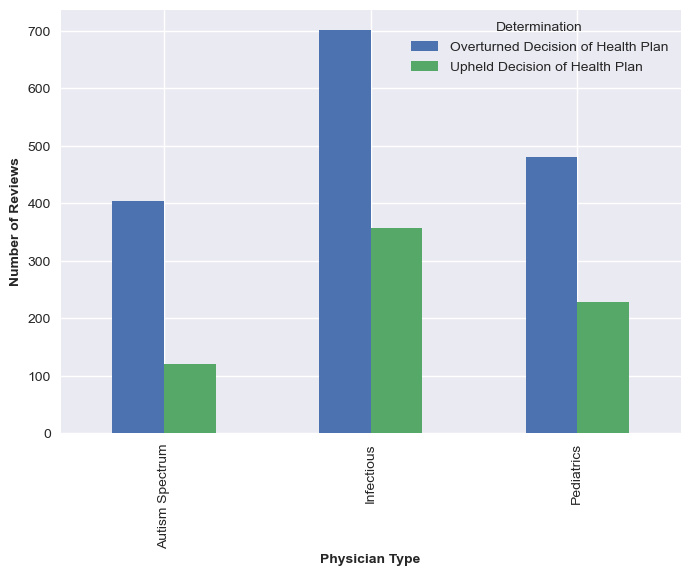

In [80]:
#This code prepares the plot of determination by Physician Type
df.pivot(index="Physician Type", 
         columns="Determination",
         values="Total").plot(kind='bar')

plt.rc('xtick',labelsize=5)

plt.ylabel('Number of Reviews', fontweight='bold',fontsize=10)
plt.xlabel('Physician Type', fontweight='bold',fontsize=10)

plt.show()

<Axes: xlabel='Physician Type'>

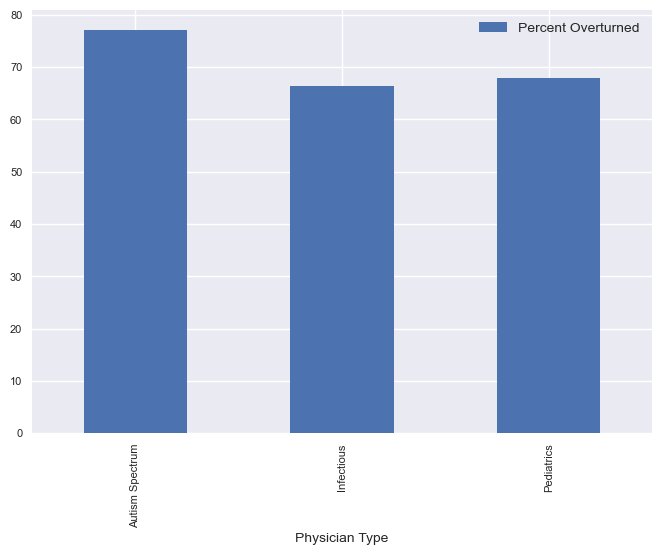

In [81]:
#This code generates a bar chart of the percent overturned by Physician Type

percent_df=pd.DataFrame(o_percent_by_pt,columns=['Physician Type','Percent Overturned','Total Reviews'])
percent_df.set_index('Physician Type', inplace=True)
percent_df.drop('Total Reviews',axis=1,inplace=True)
percent_df.plot(kind='bar',fontsize=8)

In [82]:
#This code generates a data frame focused on overturned by Physician Type
row=0
imr_df_diag=[]
while row < len(imr_df):
    if imr_df.at[row,'Determination']=='Overturned Decision of Health Plan':
        if imr_df.at[row,'Diagnosis Category'] in ('Infectious','Autism Spectrum','Pediatrics'):
            imr_df_diag.append(imr_df.loc[row])
    row += 1
          
imr_df_diag=pd.DataFrame(imr_df_diag)

In [83]:
#This code groups the Physician Type and totals that were overturned
imr_df_diag_year = imr_df_diag.groupby(['Report Year', 'Diagnosis Category']).size().reset_index(name='counts')
imr_df_diag_year.columns=['Year','Physician Type','Total']

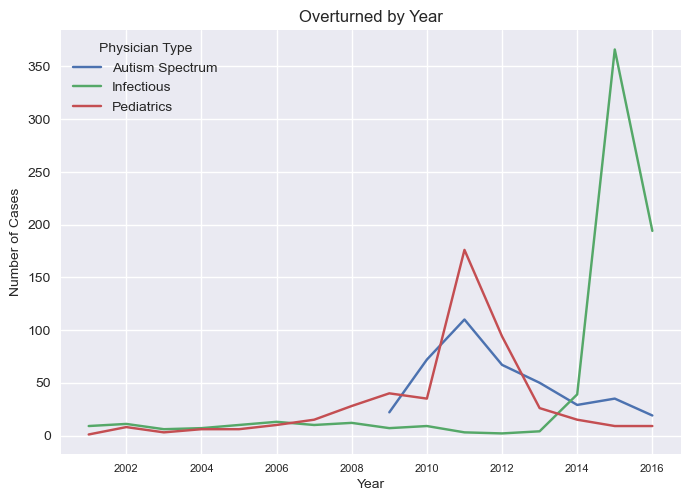

In [84]:
#This code details out a line graph by Year for the 3 outliers with high overturn rates.

pivot = imr_df_diag_year.pivot(index='Year', columns='Physician Type', values='Total')
ax = pivot.plot(kind='line', stacked=False)
ax.set_axisbelow(True)
ax.grid(zorder=0)
ax.tick_params(axis='x', labelsize=8)
plt.title('Overturned by Year')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.show()

In [85]:
# This code groups the orthepedic results by year

imr_df_orth = imr_df_orth.groupby(['Report Year', 'Determination']).size().reset_index(name='counts')
imr_df_orth.columns=['Year','Determination','Total']

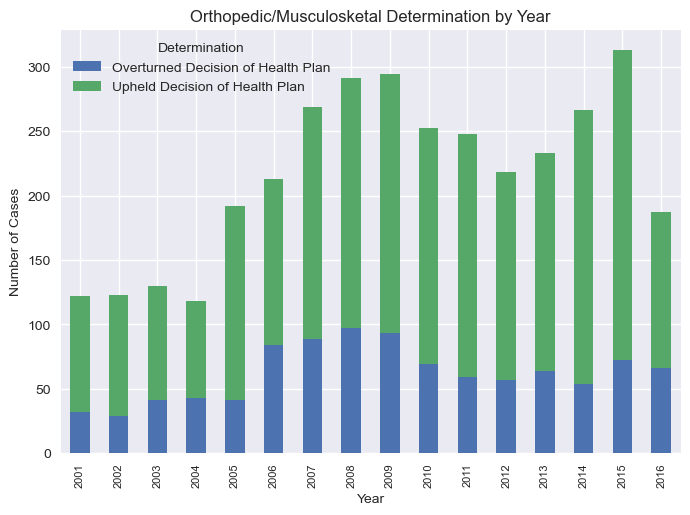

In [86]:
#This code generates a stacked bar chart of the orthepedic results by year (overturned vs upheld)

pivot = imr_df_orth.pivot(index='Year', columns='Determination', values='Total')
ax = pivot.plot(kind='bar', stacked=True)
ax.set_axisbelow(True)
ax.grid(zorder=0)
ax.tick_params(axis='x', labelsize=8)
plt.title('Orthopedic/Musculosketal Determination by Year')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.show()

# Andrews Analysis

In [87]:
#Using string formatting to get a general overview of the dataset. 

print(f"The dataset has {len(imr_df.columns)} columns and {len(imr_df)} rows. \
It uses metrics from {len(imr_df['Report Year'].unique())} years, \
{len(imr_df['Diagnosis Category'].unique())} diagnosis categories, \
{len(imr_df['Diagnosis Sub Category'].unique())} diagnosis sub categories, \
{len(imr_df['Treatment Category'].unique())} treatment categories, \
{len(imr_df['Treatment Sub Category'].unique())} treatment sub categories, \
whether or not the determination was upheld or overturned, \
{len(imr_df['Type'].unique())} determination types, \
{len(imr_df['Age Range'].unique())} age ranges, \
{len(imr_df['Patient Gender'].unique())} patient genders, \
and a report on findings for each reference ID")

The dataset has 18 columns and 19245 rows. It uses metrics from 16 years, 30 diagnosis categories, 279 diagnosis sub categories, 32 treatment categories, 284 treatment sub categories, whether or not the determination was upheld or overturned, 3 determination types, 8 age ranges, 3 patient genders, and a report on findings for each reference ID


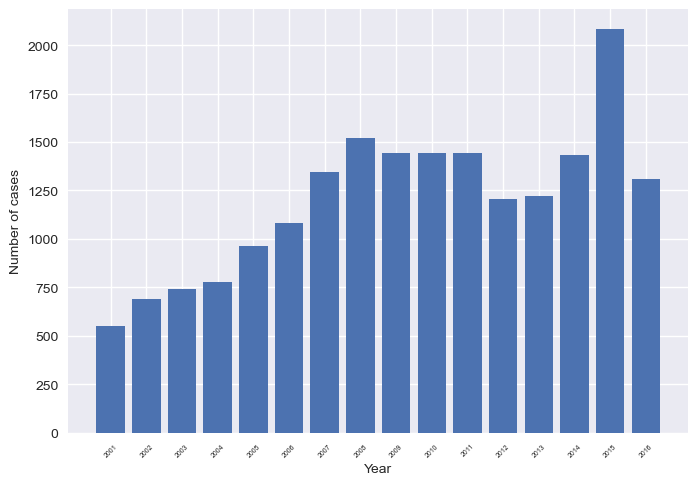

In [88]:
#This is a bar chart that shows the distribution of cases by year. 

#Creating bar chart
year_counts = imr_df.groupby('Report Year').size().reset_index(name='Number of cases')
plt.bar(year_counts['Report Year'], year_counts['Number of cases'])
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.grid(zorder=0)
plt.xticks(year_counts['Report Year'], rotation=45)
plt.gca().set_axisbelow(True)
plt.show() 

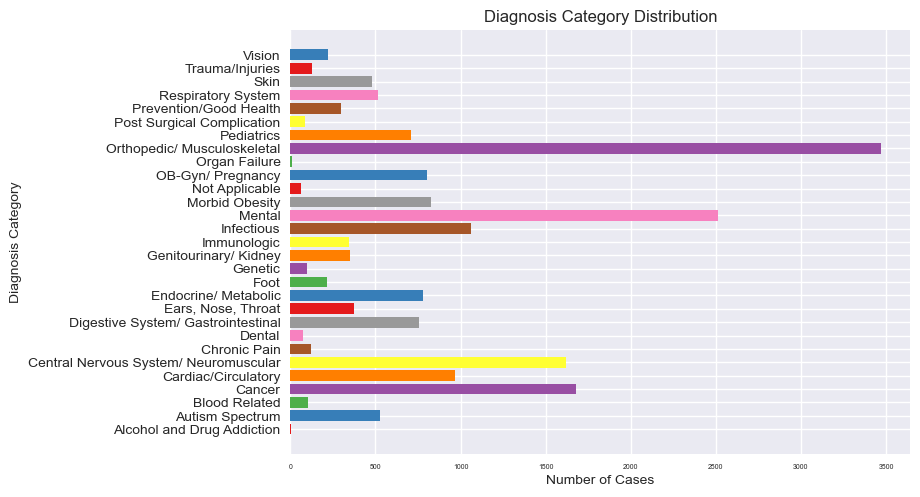

In [89]:
#This horizontal bar plot shows the distribution of diagnosis categories.

#Creating horizontal bar chart
diagnosis_counts = imr_df.groupby('Diagnosis Category')['Reference ID'].count()
colors = sns.color_palette('Set1', n_colors=len(diagnosis_counts))
plt.barh(diagnosis_counts.index, diagnosis_counts.values, color=colors)
plt.xlabel('Number of Cases')
plt.ylabel('Diagnosis Category')
plt.title('Diagnosis Category Distribution')
plt.grid(axis='x',zorder=0)
plt.yticks(np.arange(len(diagnosis_counts)), diagnosis_counts.index, fontsize=10, y=0.02)
plt.show() 

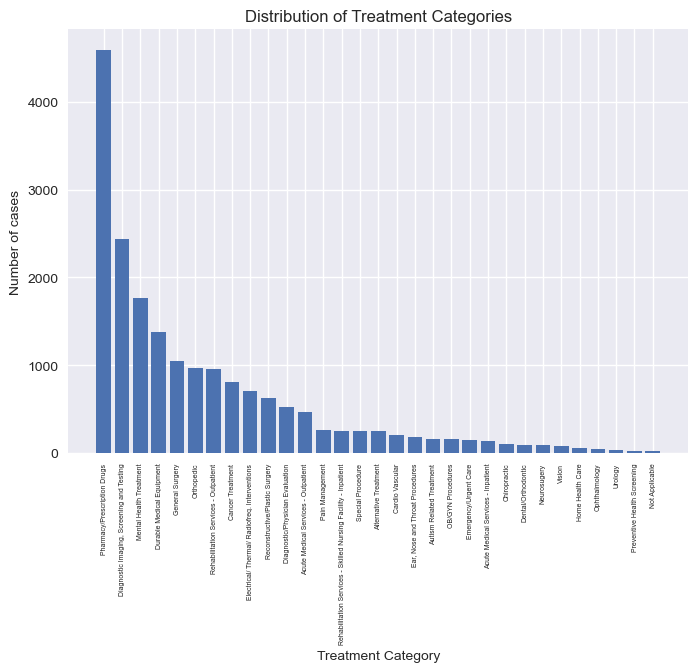

In [90]:
#This is a vertical bar chart that shows the distribution of treatment categories.

#Creating bar chart
tc = imr_df.groupby('Treatment Category').size().reset_index(name='Number of cases')
ftc = tc[tc['Number of cases'] >= 1]
sftc = ftc.sort_values('Number of cases', ascending=False)
plt.bar(sftc['Treatment Category'], sftc['Number of cases'])
plt.title('Distribution of Treatment Categories')
plt.xlabel('Treatment Category')
plt.ylabel('Number of cases')
plt.grid(zorder=0)
plt.xticks(sftc['Treatment Category'], rotation=90)
plt.gca().set_axisbelow(True)
plt.show()

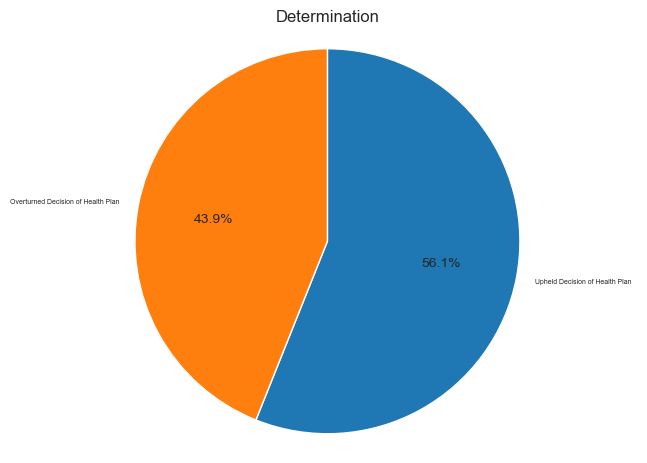

In [91]:
#This is a chart that shows the percent of overturned or upheld determinations.

#Creating pie chart
counts = imr_df['Determination'].value_counts()
colors = ['#1f77b4', '#ff7f0e']
ax = counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, 
            startangle=90, counterclock=False, 
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
ax.set_ylabel('')
plt.axis('equal')
plt.title('Determination')
plt.show()

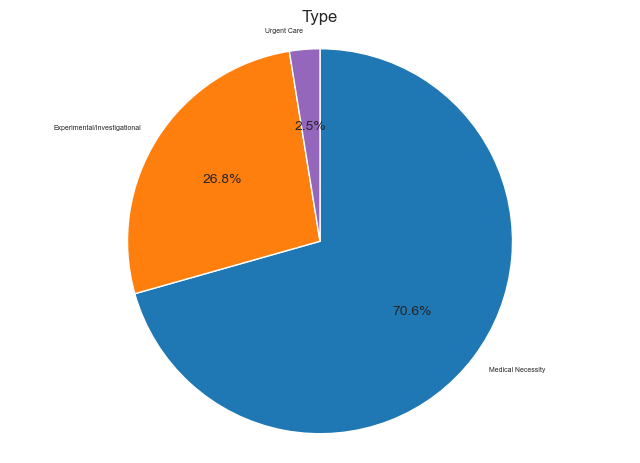

In [92]:
#This chart shows the percentage distribution of case medical types.

#Creating pie chart
counts = imr_df['Type'].value_counts()
colors = ['#1f77b4', '#ff7f0e', '#9467bd']
ax = counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, 
            startangle=90, counterclock=False, 
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
ax.set_ylabel('')
plt.axis('equal')
plt.title('Type')
plt.show()

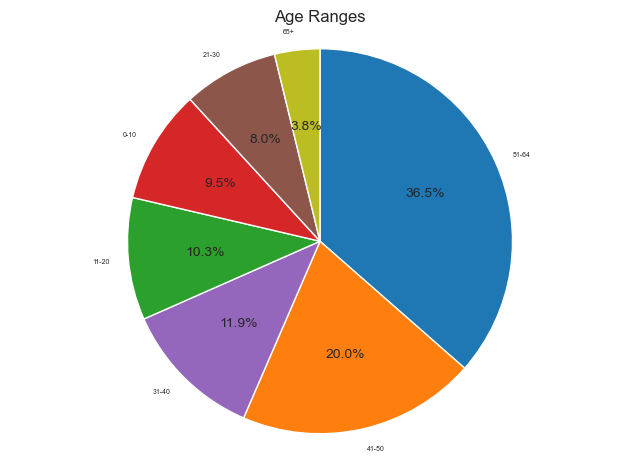

In [93]:
#This chart shows the percentage distribution of age ranges.

#Creating pie chart
counts = imr_df['Age Range'].value_counts()
colors = ['#1f77b4', '#ff7f0e', '#9467bd', '#2ca02c', '#d62728', '#8c564b', '#bcbd22']
ax = counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, 
            startangle=90, counterclock=False, 
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
ax.set_ylabel('')
plt.axis('equal')
plt.title('Age Ranges')
plt.show()

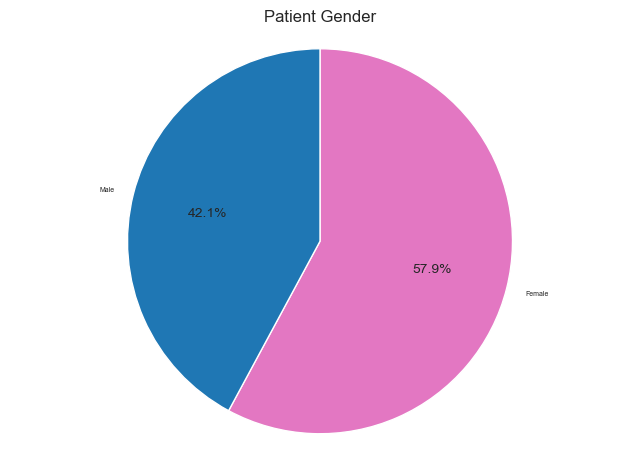

In [94]:
#This chart shows the percentage distribution of male and female patient sex

#Creating pie chart
counts = imr_df['Patient Gender'].value_counts()
colors = ['#e377c2', '#1f77b4']
ax = counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, 
            startangle=90, counterclock=False, 
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
ax.set_ylabel('')
plt.axis('equal')
plt.title('Patient Gender')
plt.show()

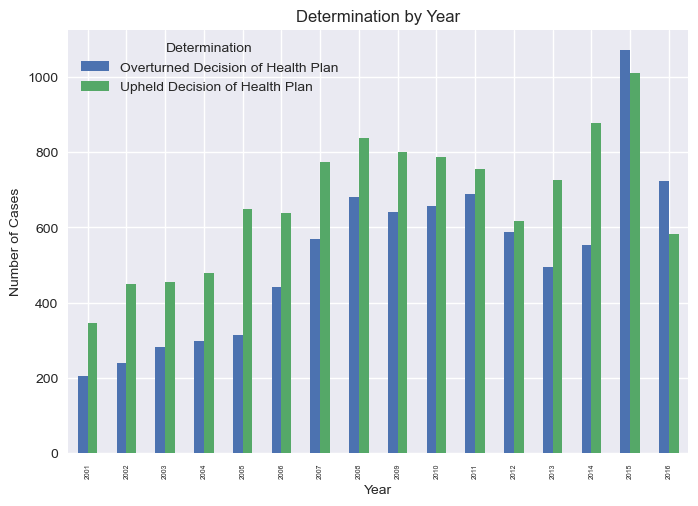

In [95]:
#This bar chart shows the distribution of upheld and overturned determinations by year.

#Creating bar chart
counts = imr_df.groupby(['Report Year', 'Determination']).size().reset_index(name='counts')
pivot = counts.pivot(index='Report Year', columns='Determination', values='counts')
ax = pivot.plot(kind='bar', stacked=False)
ax.set_axisbelow(True)
ax.grid(zorder=0)
plt.title('Determination by Year')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.show()

# Andrew's Deep Dive Analysis on Cancer

In [96]:
cancer_df = imr_df[imr_df['Diagnosis Category'] == 'Cancer']

cancer_df['Diagnosis Sub Category'].unique()

array(['Other', 'Breast Cancer', 'Ovarian Cancer', 'Skin Cancer', nan,
       'Throat/ Neck Cancer', 'Leukemia', 'Colon Cancer',
       'Lymph Nodes Cancer', 'Lung Cancer', 'Blood Cancer',
       'Liver Cancer', 'Pancreas Cancer', 'Renal Cancer',
       'Prostate Cancer', 'Cervical Cancer', 'Brain Cancer',
       'Esophagus Cancer', 'Uterine Cancer', 'Bone Cancer'], dtype=object)

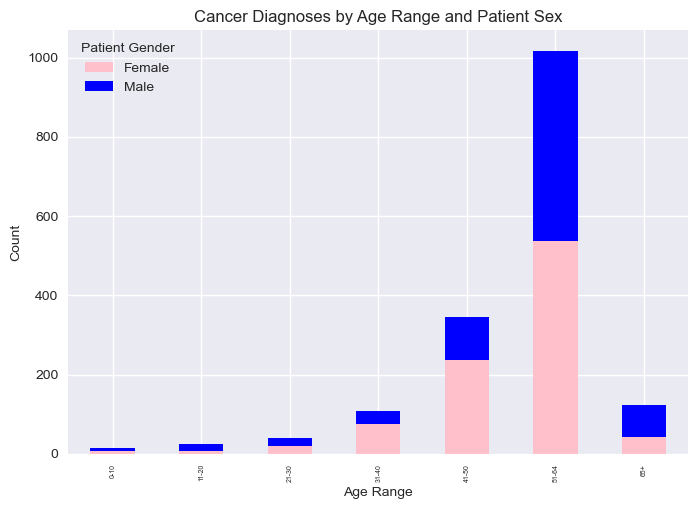

In [97]:
# Group the DataFrame by age range and patient gender and count the occurrences
grouped_df = cancer_df.groupby(['Age Range', 'Patient Gender']).size().unstack()
grouped_df.plot(kind='bar', stacked=True, color=['pink', 'blue'])
plt.title('Cancer Diagnoses by Age Range and Patient Sex')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.show()

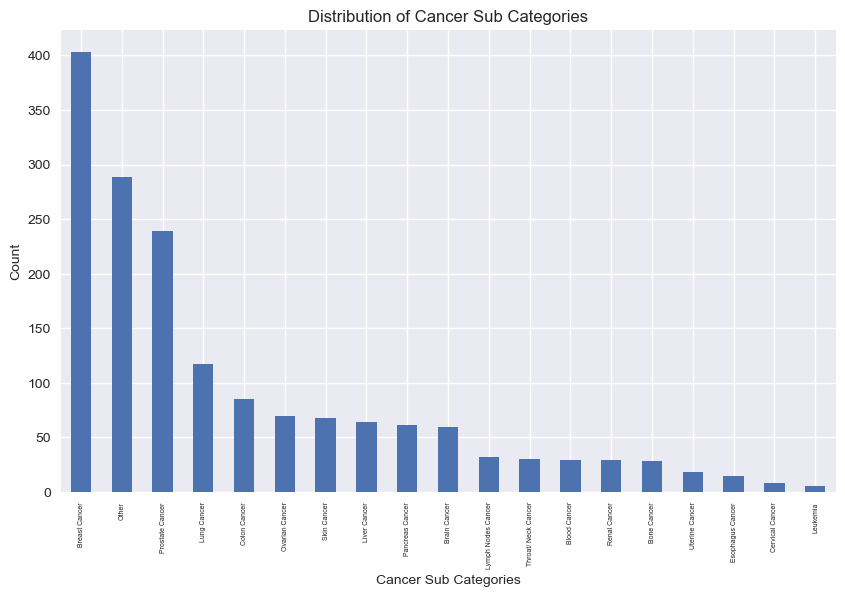

In [98]:
# Count the occurrences of each cancer subtype
subtype_counts = cancer_df['Diagnosis Sub Category'].value_counts()
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
subtype_counts.plot(kind='bar')
plt.title('Distribution of Cancer Sub Categories')
plt.xlabel('Cancer Sub Categories')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

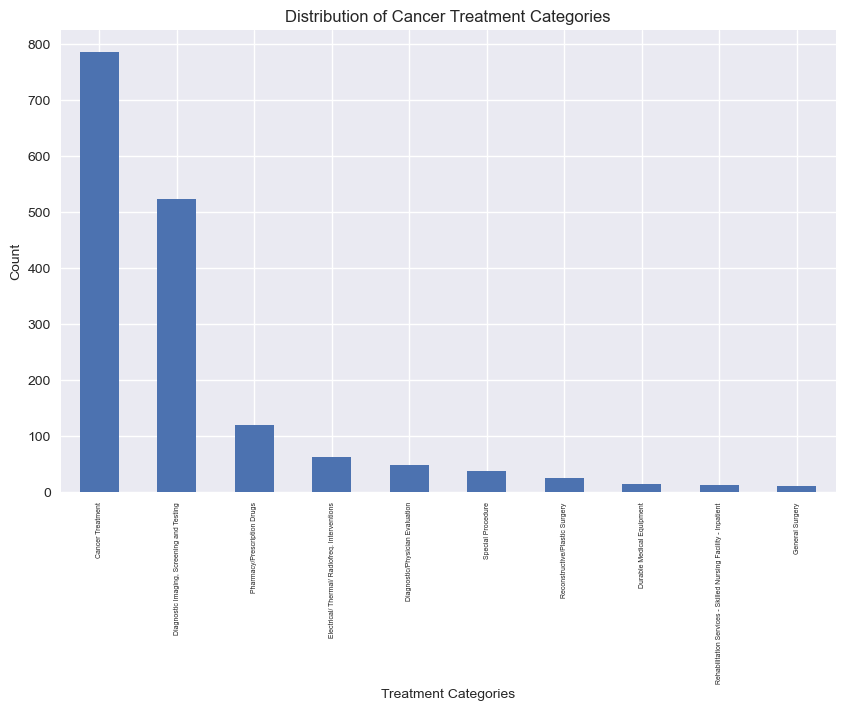

In [99]:
# Count the occurrences of each cancer subtype
subtype_counts = cancer_df['Treatment Category'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
subtype_counts.plot(kind='bar')
plt.title('Distribution of Cancer Treatment Categories')
plt.xlabel('Treatment Categories')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

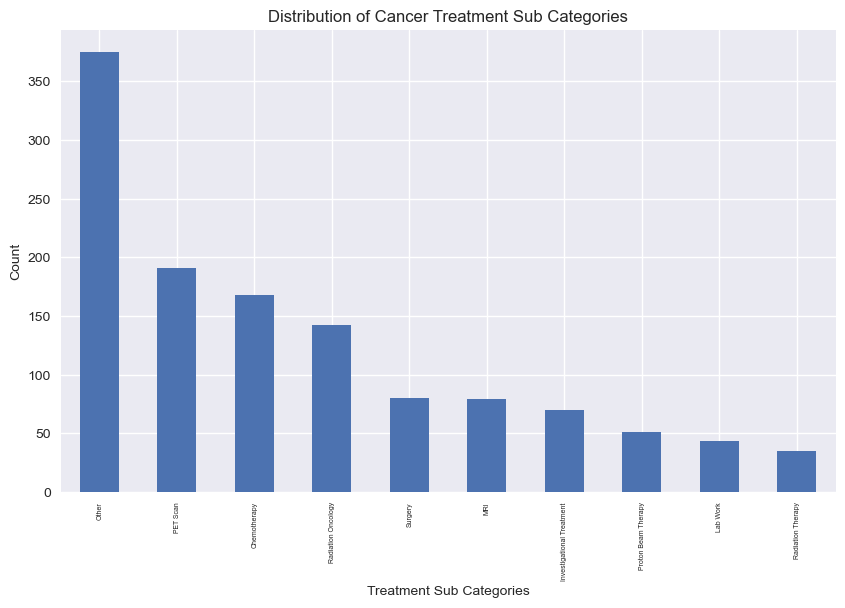

In [100]:
# Count the occurrences of each cancer subtype
subtype_counts = cancer_df['Treatment Sub Category'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
subtype_counts.plot(kind='bar')
plt.title('Distribution of Cancer Treatment Sub Categories')
plt.xlabel('Treatment Sub Categories')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Andrew's Positive/Negative Sentiment Analysis

In [101]:
#Duplicating dataset to not alter the original
andrew_imr = imr_df

In [102]:
#Adding sentiment analysis and sentiment columns
from textblob import TextBlob

andrew_imr['sentiment'] = andrew_imr['findings_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

andrew_imr['sentiment_label'] = andrew_imr['sentiment'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))


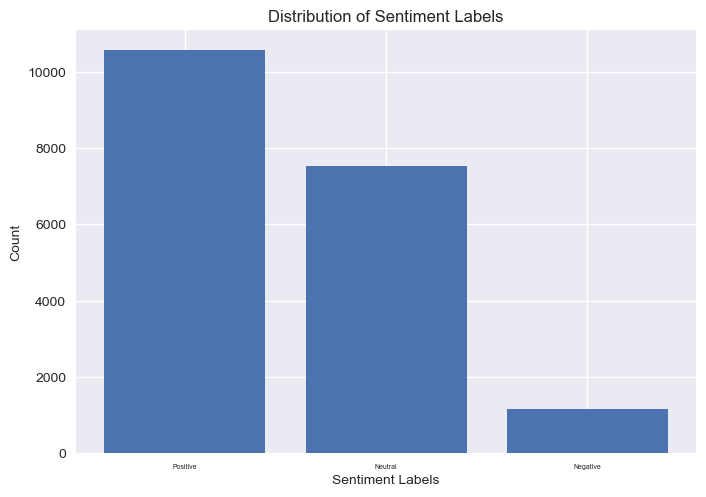

In [103]:
# Count the frequency of sentiment labels
sentiment_counts = andrew_imr['sentiment_label'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.show()

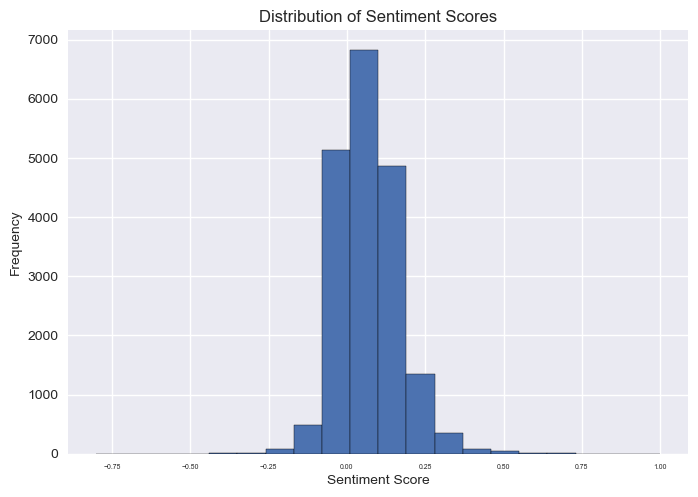

In [104]:
# Create a histogram of sentiment scores
plt.hist(andrew_imr['sentiment'], bins=20, edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

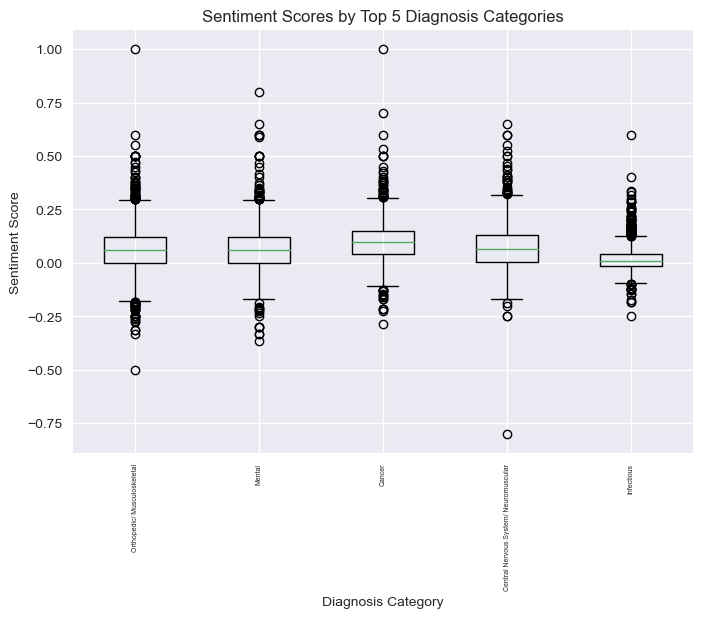

In [105]:
# Select the top 5 categories based on frequency
top_categories = andrew_imr['Diagnosis Category'].value_counts().nlargest(5).index
data = [andrew_imr[andrew_imr['Diagnosis Category'] == category]['sentiment'] for category in top_categories]
plt.boxplot(data)
plt.xticks(range(1, len(top_categories) + 1), top_categories, rotation=90)
plt.xlabel('Diagnosis Category')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores by Top 5 Diagnosis Categories')
plt.show()

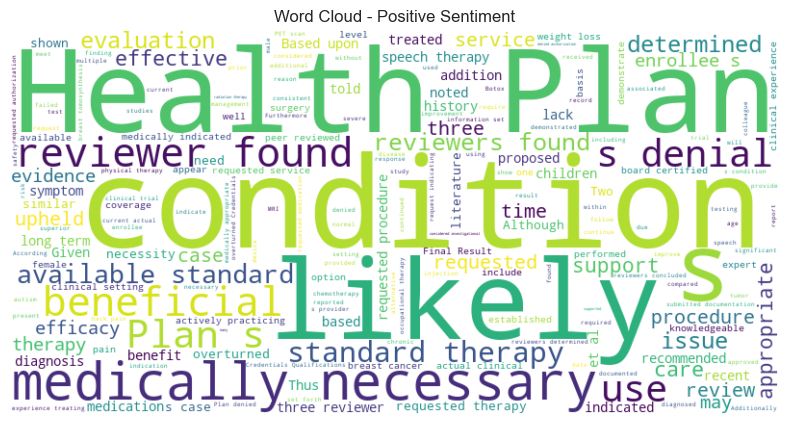

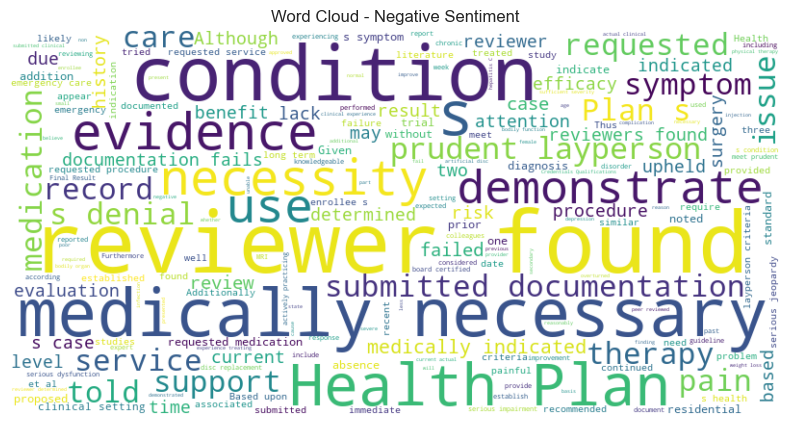

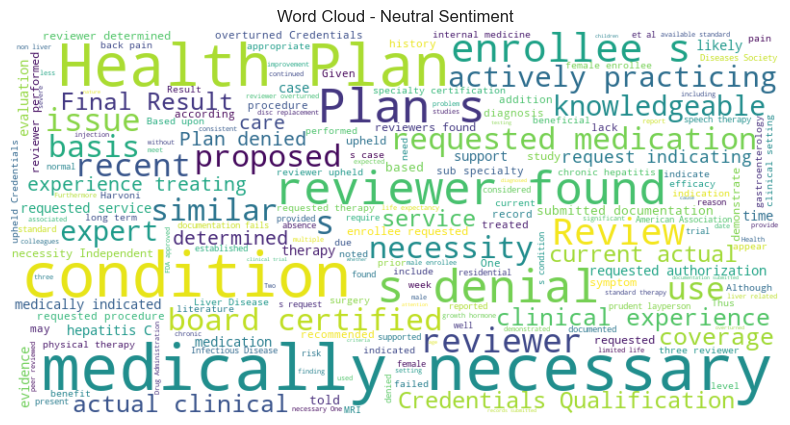

In [106]:
from wordcloud import WordCloud, STOPWORDS

# Define your additional stop words
additional_stopwords = {'patient', 'treatment', 'patients', 'treatments', 'year', 'old', 'medical', 'physician'}

positive_text = ' '.join(andrew_imr[andrew_imr['sentiment_label'] == 'Positive']['findings_cleaned'])
negative_text = ' '.join(andrew_imr[andrew_imr['sentiment_label'] == 'Negative']['findings_cleaned'])
neutral_text = ' '.join(andrew_imr[andrew_imr['sentiment_label'] == 'Neutral']['findings_cleaned'])

# Creating positive word cloud
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS.union(additional_stopwords)).generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Sentiment')
plt.show()

# Creating negative word cloud
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS.union(additional_stopwords)).generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Sentiment')
plt.show()

# Creating neutral word cloud
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS.union(additional_stopwords)).generate(neutral_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Neutral Sentiment')
plt.show()